In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [22]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [23]:
model_version_old = "0.0.0.5"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 11520/11520 (last)
505/505  - 6s 11ms/step - loss: 413.7224 - reconstruction_loss: 412.1891 - kl_loss: 1.5333

In [31]:
model_version = "0.0.0.9_lr0.0001_50moreepochs"
os.system('mkdir ' + base_dir + '/weights_vae_' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights_vae_' + model_version + '/weights.{epoch:02d}-{loss:.2f}.h5', monitor='loss',
    verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch', period=128)


history_callback = vae.fit(x_train, epochs=50 * batch_size, batch_size=batch_size)


vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2793 - reconstruction_loss: 411.7122 - kl_loss: 1.5670
Epoch 2/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2998 - reconstruction_loss: 411.7330 - kl_loss: 1.5669
Epoch 3/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2615 - reconstruction_loss: 411.6944 - kl_loss: 1.5671
Epoch 4/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2509 - reconstruction_loss: 411.6853 - kl_loss: 1.5656
Epoch 5/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2912 - reconstruction_loss: 411.7249 - kl_loss: 1.5663
Epoch 6/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.2276 - reconstruction_loss: 411.6612 - kl_loss: 1.5664
Epoch 7/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2836 - reconstruction_loss: 411.7167 - kl_loss: 1.5669
Epoch 8/6400
505/505 [==========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2925 - reconstruction_loss: 411.7255 - kl_loss: 1.5669
Epoch 60/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2724 - reconstruction_loss: 411.7047 - kl_loss: 1.5677
Epoch 61/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2290 - reconstruction_loss: 411.6622 - kl_loss: 1.5668
Epoch 62/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2691 - reconstruction_loss: 411.7029 - kl_loss: 1.5662
Epoch 63/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2817 - reconstruction_loss: 411.7153 - kl_loss: 1.5664
Epoch 64/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2749 - reconstruction_loss: 411.7080 - kl_loss: 1.5669
Epoch 65/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2386 - reconstruction_loss: 411.6711 - kl_loss: 1.5675
Epoch 66/6400
505/505 [==============================] 

505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6892 - kl_loss: 1.5665
Epoch 119/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2888 - reconstruction_loss: 411.7222 - kl_loss: 1.5666
Epoch 120/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2214 - reconstruction_loss: 411.6550 - kl_loss: 1.5664
Epoch 121/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3310 - reconstruction_loss: 411.7644 - kl_loss: 1.5667
Epoch 122/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2601 - reconstruction_loss: 411.6939 - kl_loss: 1.5662
Epoch 123/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3233 - reconstruction_loss: 411.7570 - kl_loss: 1.5663
Epoch 124/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2718 - reconstruction_loss: 411.7050 - kl_loss: 1.5669
Epoch 125/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3002 - reconstruction_loss: 411.7338 - kl_loss: 1.5664
Epoch 178/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2952 - reconstruction_loss: 411.7287 - kl_loss: 1.5664
Epoch 179/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2770 - reconstruction_loss: 411.7098 - kl_loss: 1.5673
Epoch 180/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2708 - reconstruction_loss: 411.7031 - kl_loss: 1.5677
Epoch 181/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2391 - reconstruction_loss: 411.6719 - kl_loss: 1.5671
Epoch 182/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2727 - reconstruction_loss: 411.7058 - kl_loss: 1.5670
Epoch 183/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2265 - reconstruction_loss: 411.6590 - kl_loss: 1.5676
Epoch 184/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2621 - reconstruction_loss: 411.6959 - kl_loss: 1.5661
Epoch 237/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2493 - reconstruction_loss: 411.6827 - kl_loss: 1.5667
Epoch 238/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2727 - reconstruction_loss: 411.7064 - kl_loss: 1.5663
Epoch 239/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1795 - reconstruction_loss: 411.6129 - kl_loss: 1.5666
Epoch 240/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2237 - reconstruction_loss: 411.6564 - kl_loss: 1.5674
Epoch 241/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2579 - reconstruction_loss: 411.6913 - kl_loss: 1.5666
Epoch 242/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2613 - reconstruction_loss: 411.6946 - kl_loss: 1.5666
Epoch 243/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6935 - kl_loss: 1.5672
Epoch 296/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2849 - reconstruction_loss: 411.7178 - kl_loss: 1.5671
Epoch 297/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2823 - reconstruction_loss: 411.7156 - kl_loss: 1.5666
Epoch 298/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2257 - reconstruction_loss: 411.6586 - kl_loss: 1.5671
Epoch 299/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3131 - reconstruction_loss: 411.7463 - kl_loss: 1.5668
Epoch 300/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2498 - reconstruction_loss: 411.6837 - kl_loss: 1.5661
Epoch 301/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3619 - reconstruction_loss: 411.7959 - kl_loss: 1.5660
Epoch 302/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2298 - reconstruction_loss: 411.6629 - kl_loss: 1.5669
Epoch 355/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2627 - reconstruction_loss: 411.6960 - kl_loss: 1.5667
Epoch 356/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2343 - reconstruction_loss: 411.6672 - kl_loss: 1.5672
Epoch 357/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2354 - reconstruction_loss: 411.6683 - kl_loss: 1.5671
Epoch 358/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2800 - reconstruction_loss: 411.7127 - kl_loss: 1.5674
Epoch 359/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2138 - reconstruction_loss: 411.6475 - kl_loss: 1.5663
Epoch 360/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2647 - reconstruction_loss: 411.6979 - kl_loss: 1.5667
Epoch 361/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2710 - reconstruction_loss: 411.7037 - kl_loss: 1.5673
Epoch 414/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2613 - reconstruction_loss: 411.6940 - kl_loss: 1.5673
Epoch 415/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2761 - reconstruction_loss: 411.7091 - kl_loss: 1.5670
Epoch 416/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2407 - reconstruction_loss: 411.6736 - kl_loss: 1.5671
Epoch 417/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2310 - reconstruction_loss: 411.6637 - kl_loss: 1.5674
Epoch 418/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2544 - reconstruction_loss: 411.6881 - kl_loss: 1.5663
Epoch 419/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2266 - reconstruction_loss: 411.6594 - kl_loss: 1.5671
Epoch 420/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2858 - reconstruction_loss: 411.7186 - kl_loss: 1.5673
Epoch 473/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2599 - reconstruction_loss: 411.6926 - kl_loss: 1.5673
Epoch 474/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2839 - reconstruction_loss: 411.7167 - kl_loss: 1.5672
Epoch 475/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2757 - reconstruction_loss: 411.7086 - kl_loss: 1.5671
Epoch 476/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2868 - reconstruction_loss: 411.7201 - kl_loss: 1.5667
Epoch 477/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7277 - kl_loss: 1.5667
Epoch 478/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2923 - reconstruction_loss: 411.7252 - kl_loss: 1.5671
Epoch 479/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2481 - reconstruction_loss: 411.6807 - kl_loss: 1.5674
Epoch 532/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2429 - reconstruction_loss: 411.6754 - kl_loss: 1.5675
Epoch 533/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2167 - reconstruction_loss: 411.6497 - kl_loss: 1.5670
Epoch 534/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2494 - reconstruction_loss: 411.6828 - kl_loss: 1.5666
Epoch 535/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2525 - reconstruction_loss: 411.6852 - kl_loss: 1.5674
Epoch 536/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2494 - reconstruction_loss: 411.6834 - kl_loss: 1.5660
Epoch 537/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2732 - reconstruction_loss: 411.7068 - kl_loss: 1.5664
Epoch 538/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2648 - reconstruction_loss: 411.6983 - kl_loss: 1.5666
Epoch 591/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3309 - reconstruction_loss: 411.7640 - kl_loss: 1.5669
Epoch 592/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2888 - reconstruction_loss: 411.7208 - kl_loss: 1.5681
Epoch 593/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2442 - reconstruction_loss: 411.6771 - kl_loss: 1.5671
Epoch 594/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2370 - reconstruction_loss: 411.6701 - kl_loss: 1.5669
Epoch 595/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2377 - reconstruction_loss: 411.6703 - kl_loss: 1.5674
Epoch 596/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2639 - reconstruction_loss: 411.6967 - kl_loss: 1.5672
Epoch 597/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2466 - reconstruction_loss: 411.6801 - kl_loss: 1.5665
Epoch 650/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2869 - reconstruction_loss: 411.7196 - kl_loss: 1.5673
Epoch 651/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2541 - reconstruction_loss: 411.6874 - kl_loss: 1.5667
Epoch 652/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2246 - reconstruction_loss: 411.6572 - kl_loss: 1.5673
Epoch 653/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2356 - reconstruction_loss: 411.6690 - kl_loss: 1.5666
Epoch 654/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2629 - reconstruction_loss: 411.6961 - kl_loss: 1.5668
Epoch 655/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2718 - reconstruction_loss: 411.7050 - kl_loss: 1.5668
Epoch 656/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2920 - reconstruction_loss: 411.7250 - kl_loss: 1.5670
Epoch 709/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2835 - reconstruction_loss: 411.7164 - kl_loss: 1.5671
Epoch 710/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3382 - reconstruction_loss: 411.7719 - kl_loss: 1.5663
Epoch 711/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2462 - reconstruction_loss: 411.6799 - kl_loss: 1.5663
Epoch 712/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2572 - reconstruction_loss: 411.6898 - kl_loss: 1.5674
Epoch 713/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2796 - reconstruction_loss: 411.7127 - kl_loss: 1.5669
Epoch 714/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1875 - reconstruction_loss: 411.6191 - kl_loss: 1.5685
Epoch 715/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2426 - reconstruction_loss: 411.6750 - kl_loss: 1.5676
Epoch 768/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2911 - reconstruction_loss: 411.7241 - kl_loss: 1.5670
Epoch 769/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2575 - reconstruction_loss: 411.6913 - kl_loss: 1.5662
Epoch 770/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2427 - reconstruction_loss: 411.6755 - kl_loss: 1.5673
Epoch 771/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2906 - reconstruction_loss: 411.7237 - kl_loss: 1.5669
Epoch 772/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2460 - reconstruction_loss: 411.6790 - kl_loss: 1.5669
Epoch 773/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2434 - reconstruction_loss: 411.6765 - kl_loss: 1.5669
Epoch 774/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7071 - kl_loss: 1.5665
Epoch 827/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2128 - reconstruction_loss: 411.6466 - kl_loss: 1.5662
Epoch 828/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3434 - reconstruction_loss: 411.7774 - kl_loss: 1.5660
Epoch 829/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2668 - reconstruction_loss: 411.7003 - kl_loss: 1.5665
Epoch 830/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2242 - reconstruction_loss: 411.6567 - kl_loss: 1.5675
Epoch 831/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2791 - reconstruction_loss: 411.7120 - kl_loss: 1.5671
Epoch 832/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2921 - reconstruction_loss: 411.7251 - kl_loss: 1.5670
Epoch 833/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3165 - reconstruction_loss: 411.7499 - kl_loss: 1.5666
Epoch 886/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2865 - reconstruction_loss: 411.7193 - kl_loss: 1.5673
Epoch 887/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2214 - reconstruction_loss: 411.6537 - kl_loss: 1.5677
Epoch 888/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2880 - reconstruction_loss: 411.7213 - kl_loss: 1.5667
Epoch 889/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2138 - reconstruction_loss: 411.6468 - kl_loss: 1.5670
Epoch 890/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2646 - reconstruction_loss: 411.6970 - kl_loss: 1.5675
Epoch 891/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2407 - reconstruction_loss: 411.6738 - kl_loss: 1.5669
Epoch 892/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2781 - reconstruction_loss: 411.7110 - kl_loss: 1.5671
Epoch 945/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2410 - reconstruction_loss: 411.6738 - kl_loss: 1.5672
Epoch 946/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6929 - kl_loss: 1.5668
Epoch 947/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2410 - reconstruction_loss: 411.6739 - kl_loss: 1.5671
Epoch 948/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2434 - reconstruction_loss: 411.6770 - kl_loss: 1.5665
Epoch 949/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3104 - reconstruction_loss: 411.7436 - kl_loss: 1.5668
Epoch 950/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2327 - reconstruction_loss: 411.6655 - kl_loss: 1.5671
Epoch 951/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3103 - reconstruction_loss: 411.7435 - kl_loss: 1.5667
Epoch 1004/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2939 - reconstruction_loss: 411.7265 - kl_loss: 1.5674
Epoch 1005/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2609 - reconstruction_loss: 411.6943 - kl_loss: 1.5665
Epoch 1006/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2818 - reconstruction_loss: 411.7145 - kl_loss: 1.5673
Epoch 1007/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2383 - reconstruction_loss: 411.6720 - kl_loss: 1.5662
Epoch 1008/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1960 - reconstruction_loss: 411.6291 - kl_loss: 1.5668
Epoch 1009/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2026 - reconstruction_loss: 411.6352 - kl_loss: 1.5674
Epoch 1010/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2956 - reconstruction_loss: 411.7286 - kl_loss: 1.5670
Epoch 1063/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2403 - reconstruction_loss: 411.6729 - kl_loss: 1.5674
Epoch 1064/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2329 - reconstruction_loss: 411.6662 - kl_loss: 1.5668
Epoch 1065/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6956 - kl_loss: 1.5668
Epoch 1066/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2783 - reconstruction_loss: 411.7115 - kl_loss: 1.5668
Epoch 1067/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2841 - reconstruction_loss: 411.7170 - kl_loss: 1.5671
Epoch 1068/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6932 - kl_loss: 1.5666
Epoch 1069/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2926 - reconstruction_loss: 411.7249 - kl_loss: 1.5677
Epoch 1122/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2188 - reconstruction_loss: 411.6516 - kl_loss: 1.5671
Epoch 1123/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2152 - reconstruction_loss: 411.6477 - kl_loss: 1.5675
Epoch 1124/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3023 - reconstruction_loss: 411.7369 - kl_loss: 1.5654
Epoch 1125/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2851 - reconstruction_loss: 411.7182 - kl_loss: 1.5669
Epoch 1126/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2684 - reconstruction_loss: 411.7019 - kl_loss: 1.5665
Epoch 1127/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1865 - reconstruction_loss: 411.6194 - kl_loss: 1.5671
Epoch 1128/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2239 - reconstruction_loss: 411.6561 - kl_loss: 1.5678
Epoch 1181/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2822 - reconstruction_loss: 411.7154 - kl_loss: 1.5669
Epoch 1182/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2285 - reconstruction_loss: 411.6613 - kl_loss: 1.5672
Epoch 1183/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2362 - reconstruction_loss: 411.6691 - kl_loss: 1.5671
Epoch 1184/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2128 - reconstruction_loss: 411.6454 - kl_loss: 1.5674
Epoch 1185/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2455 - reconstruction_loss: 411.6789 - kl_loss: 1.5666
Epoch 1186/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2846 - reconstruction_loss: 411.7175 - kl_loss: 1.5671
Epoch 1187/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2426 - reconstruction_loss: 411.6763 - kl_loss: 1.5663
Epoch 1240/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2486 - reconstruction_loss: 411.6816 - kl_loss: 1.5670
Epoch 1241/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2692 - reconstruction_loss: 411.7014 - kl_loss: 1.5679
Epoch 1242/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2141 - reconstruction_loss: 411.6478 - kl_loss: 1.5663
Epoch 1243/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2765 - reconstruction_loss: 411.7097 - kl_loss: 1.5667
Epoch 1244/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2540 - reconstruction_loss: 411.6863 - kl_loss: 1.5676
Epoch 1245/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2820 - reconstruction_loss: 411.7148 - kl_loss: 1.5671
Epoch 1246/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2261 - reconstruction_loss: 411.6582 - kl_loss: 1.5679
Epoch 1299/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2592 - reconstruction_loss: 411.6919 - kl_loss: 1.5673
Epoch 1300/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2628 - reconstruction_loss: 411.6948 - kl_loss: 1.5680
Epoch 1301/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2927 - reconstruction_loss: 411.7252 - kl_loss: 1.5675
Epoch 1302/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2728 - reconstruction_loss: 411.7055 - kl_loss: 1.5673
Epoch 1303/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2496 - reconstruction_loss: 411.6831 - kl_loss: 1.5665
Epoch 1304/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2434 - reconstruction_loss: 411.6768 - kl_loss: 1.5667
Epoch 1305/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2841 - reconstruction_loss: 411.7163 - kl_loss: 1.5678
Epoch 1358/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2217 - reconstruction_loss: 411.6555 - kl_loss: 1.5662
Epoch 1359/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2620 - reconstruction_loss: 411.6954 - kl_loss: 1.5666
Epoch 1360/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2636 - reconstruction_loss: 411.6961 - kl_loss: 1.5675
Epoch 1361/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2447 - reconstruction_loss: 411.6779 - kl_loss: 1.5668
Epoch 1362/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2516 - reconstruction_loss: 411.6845 - kl_loss: 1.5671
Epoch 1363/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2972 - reconstruction_loss: 411.7298 - kl_loss: 1.5674
Epoch 1364/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2244 - reconstruction_loss: 411.6572 - kl_loss: 1.5672
Epoch 1417/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2500 - reconstruction_loss: 411.6817 - kl_loss: 1.5683
Epoch 1418/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2692 - reconstruction_loss: 411.7009 - kl_loss: 1.5683
Epoch 1419/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2995 - reconstruction_loss: 411.7324 - kl_loss: 1.5671
Epoch 1420/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2760 - reconstruction_loss: 411.7090 - kl_loss: 1.5670
Epoch 1421/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2879 - reconstruction_loss: 411.7215 - kl_loss: 1.5663
Epoch 1422/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2747 - reconstruction_loss: 411.7075 - kl_loss: 1.5672
Epoch 1423/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2812 - reconstruction_loss: 411.7136 - kl_loss: 1.5676
Epoch 1476/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2901 - reconstruction_loss: 411.7233 - kl_loss: 1.5668
Epoch 1477/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2770 - reconstruction_loss: 411.7103 - kl_loss: 1.5667
Epoch 1478/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2324 - reconstruction_loss: 411.6661 - kl_loss: 1.5663
Epoch 1479/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3003 - reconstruction_loss: 411.7334 - kl_loss: 1.5669
Epoch 1480/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2422 - reconstruction_loss: 411.6755 - kl_loss: 1.5668
Epoch 1481/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2475 - reconstruction_loss: 411.6802 - kl_loss: 1.5674
Epoch 1482/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2969 - reconstruction_loss: 411.7304 - kl_loss: 1.5665
Epoch 1535/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2925 - reconstruction_loss: 411.7257 - kl_loss: 1.5667
Epoch 1536/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2274 - reconstruction_loss: 411.6603 - kl_loss: 1.5672
Epoch 1537/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6912 - kl_loss: 1.5671
Epoch 1538/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2265 - reconstruction_loss: 411.6593 - kl_loss: 1.5672
Epoch 1539/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2634 - reconstruction_loss: 411.6961 - kl_loss: 1.5672
Epoch 1540/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2148 - reconstruction_loss: 411.6475 - kl_loss: 1.5672
Epoch 1541/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2481 - reconstruction_loss: 411.6813 - kl_loss: 1.5668
Epoch 1594/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2872 - reconstruction_loss: 411.7201 - kl_loss: 1.5671
Epoch 1595/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2534 - reconstruction_loss: 411.6868 - kl_loss: 1.5666
Epoch 1596/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2324 - reconstruction_loss: 411.6645 - kl_loss: 1.5679
Epoch 1597/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2725 - reconstruction_loss: 411.7053 - kl_loss: 1.5672
Epoch 1598/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2418 - reconstruction_loss: 411.6742 - kl_loss: 1.5676
Epoch 1599/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2753 - reconstruction_loss: 411.7091 - kl_loss: 1.5662
Epoch 1600/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2539 - reconstruction_loss: 411.6859 - kl_loss: 1.5679
Epoch 1653/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2985 - reconstruction_loss: 411.7322 - kl_loss: 1.5663
Epoch 1654/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2709 - reconstruction_loss: 411.7045 - kl_loss: 1.5664
Epoch 1655/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2527 - reconstruction_loss: 411.6850 - kl_loss: 1.5678
Epoch 1656/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7022 - kl_loss: 1.5679
Epoch 1657/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2886 - reconstruction_loss: 411.7211 - kl_loss: 1.5674
Epoch 1658/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2745 - reconstruction_loss: 411.7076 - kl_loss: 1.5669
Epoch 1659/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2570 - reconstruction_loss: 411.6907 - kl_loss: 1.5663
Epoch 1712/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2516 - reconstruction_loss: 411.6847 - kl_loss: 1.5669
Epoch 1713/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2883 - reconstruction_loss: 411.7205 - kl_loss: 1.5678
Epoch 1714/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2913 - reconstruction_loss: 411.7243 - kl_loss: 1.5670
Epoch 1715/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2169 - reconstruction_loss: 411.6509 - kl_loss: 1.5660
Epoch 1716/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2965 - reconstruction_loss: 411.7288 - kl_loss: 1.5677
Epoch 1717/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2838 - reconstruction_loss: 411.7171 - kl_loss: 1.5667
Epoch 1718/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2660 - reconstruction_loss: 411.6985 - kl_loss: 1.5675
Epoch 1771/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2571 - reconstruction_loss: 411.6905 - kl_loss: 1.5666
Epoch 1772/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3028 - reconstruction_loss: 411.7361 - kl_loss: 1.5667
Epoch 1773/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3067 - reconstruction_loss: 411.7390 - kl_loss: 1.5676
Epoch 1774/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2751 - reconstruction_loss: 411.7079 - kl_loss: 1.5672
Epoch 1775/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2510 - reconstruction_loss: 411.6836 - kl_loss: 1.5673
Epoch 1776/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2639 - reconstruction_loss: 411.6970 - kl_loss: 1.5669
Epoch 1777/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2780 - reconstruction_loss: 411.7106 - kl_loss: 1.5674
Epoch 1830/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2955 - reconstruction_loss: 411.7284 - kl_loss: 1.5672
Epoch 1831/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2242 - reconstruction_loss: 411.6569 - kl_loss: 1.5672
Epoch 1832/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2524 - reconstruction_loss: 411.6848 - kl_loss: 1.5676
Epoch 1833/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2644 - reconstruction_loss: 411.6976 - kl_loss: 1.5667
Epoch 1834/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3069 - reconstruction_loss: 411.7395 - kl_loss: 1.5673
Epoch 1835/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2540 - reconstruction_loss: 411.6867 - kl_loss: 1.5672
Epoch 1836/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2872 - reconstruction_loss: 411.7201 - kl_loss: 1.5671
Epoch 1889/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2100 - reconstruction_loss: 411.6426 - kl_loss: 1.5674
Epoch 1890/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2515 - reconstruction_loss: 411.6842 - kl_loss: 1.5673
Epoch 1891/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2232 - reconstruction_loss: 411.6559 - kl_loss: 1.5673
Epoch 1892/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2513 - reconstruction_loss: 411.6842 - kl_loss: 1.5671
Epoch 1893/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2869 - reconstruction_loss: 411.7201 - kl_loss: 1.5668
Epoch 1894/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2270 - reconstruction_loss: 411.6592 - kl_loss: 1.5678
Epoch 1895/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2808 - reconstruction_loss: 411.7133 - kl_loss: 1.5675
Epoch 1948/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2949 - reconstruction_loss: 411.7282 - kl_loss: 1.5668
Epoch 1949/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2255 - reconstruction_loss: 411.6585 - kl_loss: 1.5670
Epoch 1950/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6891 - kl_loss: 1.5666
Epoch 1951/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2670 - reconstruction_loss: 411.7000 - kl_loss: 1.5670
Epoch 1952/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2831 - reconstruction_loss: 411.7156 - kl_loss: 1.5674
Epoch 1953/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2499 - reconstruction_loss: 411.6833 - kl_loss: 1.5666
Epoch 1954/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2902 - reconstruction_loss: 411.7229 - kl_loss: 1.5673
Epoch 2007/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2139 - reconstruction_loss: 411.6467 - kl_loss: 1.5671
Epoch 2008/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2929 - reconstruction_loss: 411.7250 - kl_loss: 1.5678
Epoch 2009/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2666 - reconstruction_loss: 411.6990 - kl_loss: 1.5675
Epoch 2010/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2501 - reconstruction_loss: 411.6843 - kl_loss: 1.5657
Epoch 2011/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2693 - reconstruction_loss: 411.7027 - kl_loss: 1.5666
Epoch 2012/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2647 - reconstruction_loss: 411.6971 - kl_loss: 1.5676
Epoch 2013/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2745 - reconstruction_loss: 411.7077 - kl_loss: 1.5668
Epoch 2066/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3001 - reconstruction_loss: 411.7330 - kl_loss: 1.5671
Epoch 2067/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2643 - reconstruction_loss: 411.6971 - kl_loss: 1.5672
Epoch 2068/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2707 - reconstruction_loss: 411.7030 - kl_loss: 1.5676
Epoch 2069/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2644 - reconstruction_loss: 411.6967 - kl_loss: 1.5677
Epoch 2070/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2523 - reconstruction_loss: 411.6843 - kl_loss: 1.5680
Epoch 2071/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1767 - reconstruction_loss: 411.6090 - kl_loss: 1.5676
Epoch 2072/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2284 - reconstruction_loss: 411.6611 - kl_loss: 1.5673
Epoch 2125/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2023 - reconstruction_loss: 411.6345 - kl_loss: 1.5678
Epoch 2126/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2410 - reconstruction_loss: 411.6738 - kl_loss: 1.5672
Epoch 2127/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2356 - reconstruction_loss: 411.6678 - kl_loss: 1.5678
Epoch 2128/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2927 - reconstruction_loss: 411.7256 - kl_loss: 1.5671
Epoch 2129/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2633 - reconstruction_loss: 411.6961 - kl_loss: 1.5672
Epoch 2130/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2385 - reconstruction_loss: 411.6717 - kl_loss: 1.5668
Epoch 2131/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2549 - reconstruction_loss: 411.6883 - kl_loss: 1.5666
Epoch 2184/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2110 - reconstruction_loss: 411.6436 - kl_loss: 1.5674
Epoch 2185/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2558 - reconstruction_loss: 411.6880 - kl_loss: 1.5678
Epoch 2186/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2962 - reconstruction_loss: 411.7284 - kl_loss: 1.5677
Epoch 2187/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2599 - reconstruction_loss: 411.6925 - kl_loss: 1.5674
Epoch 2188/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2914 - reconstruction_loss: 411.7240 - kl_loss: 1.5673
Epoch 2189/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2251 - reconstruction_loss: 411.6577 - kl_loss: 1.5674
Epoch 2190/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2951 - reconstruction_loss: 411.7281 - kl_loss: 1.5671
Epoch 2243/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2481 - reconstruction_loss: 411.6807 - kl_loss: 1.5674
Epoch 2244/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2957 - reconstruction_loss: 411.7282 - kl_loss: 1.5675
Epoch 2245/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2357 - reconstruction_loss: 411.6697 - kl_loss: 1.5660
Epoch 2246/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2816 - reconstruction_loss: 411.7145 - kl_loss: 1.5672
Epoch 2247/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7135 - kl_loss: 1.5668
Epoch 2248/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2446 - reconstruction_loss: 411.6776 - kl_loss: 1.5670
Epoch 2249/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2549 - reconstruction_loss: 411.6883 - kl_loss: 1.5666
Epoch 2302/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2788 - reconstruction_loss: 411.7118 - kl_loss: 1.5671
Epoch 2303/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2503 - reconstruction_loss: 411.6830 - kl_loss: 1.5673
Epoch 2304/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2335 - reconstruction_loss: 411.6662 - kl_loss: 1.5673
Epoch 2305/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2827 - reconstruction_loss: 411.7153 - kl_loss: 1.5674
Epoch 2306/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2295 - reconstruction_loss: 411.6622 - kl_loss: 1.5673
Epoch 2307/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2519 - reconstruction_loss: 411.6850 - kl_loss: 1.5669
Epoch 2308/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2722 - reconstruction_loss: 411.7049 - kl_loss: 1.5673
Epoch 2361/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1967 - reconstruction_loss: 411.6292 - kl_loss: 1.5676
Epoch 2362/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2771 - reconstruction_loss: 411.7103 - kl_loss: 1.5669
Epoch 2363/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2202 - reconstruction_loss: 411.6530 - kl_loss: 1.5672
Epoch 2364/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2545 - reconstruction_loss: 411.6876 - kl_loss: 1.5669
Epoch 2365/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2738 - reconstruction_loss: 411.7071 - kl_loss: 1.5668
Epoch 2366/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2881 - reconstruction_loss: 411.7211 - kl_loss: 1.5670
Epoch 2367/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2541 - reconstruction_loss: 411.6875 - kl_loss: 1.5666
Epoch 2420/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2502 - reconstruction_loss: 411.6830 - kl_loss: 1.5672
Epoch 2421/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3169 - reconstruction_loss: 411.7498 - kl_loss: 1.5671
Epoch 2422/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2307 - reconstruction_loss: 411.6628 - kl_loss: 1.5680
Epoch 2423/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2904 - reconstruction_loss: 411.7233 - kl_loss: 1.5671
Epoch 2424/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2768 - reconstruction_loss: 411.7087 - kl_loss: 1.5680
Epoch 2425/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2808 - reconstruction_loss: 411.7143 - kl_loss: 1.5665
Epoch 2426/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2426 - reconstruction_loss: 411.6754 - kl_loss: 1.5672
Epoch 2479/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2486 - reconstruction_loss: 411.6817 - kl_loss: 1.5669
Epoch 2480/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2072 - reconstruction_loss: 411.6391 - kl_loss: 1.5681
Epoch 2481/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2806 - reconstruction_loss: 411.7131 - kl_loss: 1.5675
Epoch 2482/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2198 - reconstruction_loss: 411.6530 - kl_loss: 1.5668
Epoch 2483/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2769 - reconstruction_loss: 411.7100 - kl_loss: 1.5669
Epoch 2484/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2531 - reconstruction_loss: 411.6858 - kl_loss: 1.5673
Epoch 2485/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2595 - reconstruction_loss: 411.6922 - kl_loss: 1.5672
Epoch 2538/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3154 - reconstruction_loss: 411.7486 - kl_loss: 1.5668
Epoch 2539/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2409 - reconstruction_loss: 411.6742 - kl_loss: 1.5668
Epoch 2540/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2971 - reconstruction_loss: 411.7294 - kl_loss: 1.5677
Epoch 2541/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2442 - reconstruction_loss: 411.6769 - kl_loss: 1.5674
Epoch 2542/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1935 - reconstruction_loss: 411.6262 - kl_loss: 1.5673
Epoch 2543/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2730 - reconstruction_loss: 411.7062 - kl_loss: 1.5668
Epoch 2544/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2308 - reconstruction_loss: 411.6631 - kl_loss: 1.5677
Epoch 2597/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2980 - reconstruction_loss: 411.7313 - kl_loss: 1.5668
Epoch 2598/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2577 - reconstruction_loss: 411.6909 - kl_loss: 1.5668
Epoch 2599/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2885 - reconstruction_loss: 411.7203 - kl_loss: 1.5682
Epoch 2600/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2543 - reconstruction_loss: 411.6874 - kl_loss: 1.5670
Epoch 2601/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2722 - reconstruction_loss: 411.7049 - kl_loss: 1.5673
Epoch 2602/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2500 - reconstruction_loss: 411.6827 - kl_loss: 1.5674
Epoch 2603/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1832 - reconstruction_loss: 411.6161 - kl_loss: 1.5671
Epoch 2656/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2700 - reconstruction_loss: 411.7029 - kl_loss: 1.5671
Epoch 2657/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2823 - reconstruction_loss: 411.7152 - kl_loss: 1.5672
Epoch 2658/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2637 - reconstruction_loss: 411.6959 - kl_loss: 1.5678
Epoch 2659/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2173 - reconstruction_loss: 411.6493 - kl_loss: 1.5680
Epoch 2660/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2611 - reconstruction_loss: 411.6934 - kl_loss: 1.5678
Epoch 2661/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2577 - reconstruction_loss: 411.6906 - kl_loss: 1.5671
Epoch 2662/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2553 - reconstruction_loss: 411.6875 - kl_loss: 1.5678
Epoch 2715/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2411 - reconstruction_loss: 411.6731 - kl_loss: 1.5680
Epoch 2716/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2935 - reconstruction_loss: 411.7266 - kl_loss: 1.5670
Epoch 2717/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2548 - reconstruction_loss: 411.6878 - kl_loss: 1.5670
Epoch 2718/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2474 - reconstruction_loss: 411.6803 - kl_loss: 1.5671
Epoch 2719/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2723 - reconstruction_loss: 411.7053 - kl_loss: 1.5669
Epoch 2720/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2327 - reconstruction_loss: 411.6647 - kl_loss: 1.5680
Epoch 2721/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2211 - reconstruction_loss: 411.6537 - kl_loss: 1.5674
Epoch 2774/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2632 - reconstruction_loss: 411.6954 - kl_loss: 1.5677
Epoch 2775/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2650 - reconstruction_loss: 411.6979 - kl_loss: 1.5671
Epoch 2776/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2921 - reconstruction_loss: 411.7248 - kl_loss: 1.5673
Epoch 2777/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2887 - reconstruction_loss: 411.7217 - kl_loss: 1.5670
Epoch 2778/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2374 - reconstruction_loss: 411.6696 - kl_loss: 1.5678
Epoch 2779/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2404 - reconstruction_loss: 411.6725 - kl_loss: 1.5679
Epoch 2780/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2213 - reconstruction_loss: 411.6537 - kl_loss: 1.5676
Epoch 2833/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2830 - reconstruction_loss: 411.7163 - kl_loss: 1.5667
Epoch 2834/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2476 - reconstruction_loss: 411.6803 - kl_loss: 1.5673
Epoch 2835/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1576 - reconstruction_loss: 411.5908 - kl_loss: 1.5668
Epoch 2836/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2849 - reconstruction_loss: 411.7172 - kl_loss: 1.5677
Epoch 2837/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7033 - kl_loss: 1.5670
Epoch 2838/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2595 - reconstruction_loss: 411.6920 - kl_loss: 1.5675
Epoch 2839/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2550 - reconstruction_loss: 411.6880 - kl_loss: 1.5670
Epoch 2892/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3274 - reconstruction_loss: 411.7608 - kl_loss: 1.5667
Epoch 2893/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2013 - reconstruction_loss: 411.6340 - kl_loss: 1.5674
Epoch 2894/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3268 - reconstruction_loss: 411.7590 - kl_loss: 1.5678
Epoch 2895/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2785 - reconstruction_loss: 411.7118 - kl_loss: 1.5667
Epoch 2896/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1986 - reconstruction_loss: 411.6318 - kl_loss: 1.5668
Epoch 2897/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2399 - reconstruction_loss: 411.6729 - kl_loss: 1.5670
Epoch 2898/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2195 - reconstruction_loss: 411.6525 - kl_loss: 1.5670
Epoch 2951/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2559 - reconstruction_loss: 411.6881 - kl_loss: 1.5678
Epoch 2952/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2443 - reconstruction_loss: 411.6775 - kl_loss: 1.5668
Epoch 2953/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2284 - reconstruction_loss: 411.6609 - kl_loss: 1.5675
Epoch 2954/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2574 - reconstruction_loss: 411.6894 - kl_loss: 1.5679
Epoch 2955/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2392 - reconstruction_loss: 411.6714 - kl_loss: 1.5678
Epoch 2956/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2580 - reconstruction_loss: 411.6914 - kl_loss: 1.5665
Epoch 2957/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2970 - reconstruction_loss: 411.7297 - kl_loss: 1.5672
Epoch 3010/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2590 - reconstruction_loss: 411.6918 - kl_loss: 1.5671
Epoch 3011/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2536 - reconstruction_loss: 411.6863 - kl_loss: 1.5673
Epoch 3012/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2225 - reconstruction_loss: 411.6548 - kl_loss: 1.5676
Epoch 3013/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2671 - reconstruction_loss: 411.6994 - kl_loss: 1.5677
Epoch 3014/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2353 - reconstruction_loss: 411.6680 - kl_loss: 1.5673
Epoch 3015/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2603 - reconstruction_loss: 411.6936 - kl_loss: 1.5667
Epoch 3016/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2564 - reconstruction_loss: 411.6886 - kl_loss: 1.5678
Epoch 3069/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3027 - reconstruction_loss: 411.7352 - kl_loss: 1.5675
Epoch 3070/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3063 - reconstruction_loss: 411.7389 - kl_loss: 1.5674
Epoch 3071/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2492 - reconstruction_loss: 411.6820 - kl_loss: 1.5672
Epoch 3072/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2722 - reconstruction_loss: 411.7050 - kl_loss: 1.5671
Epoch 3073/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2784 - reconstruction_loss: 411.7114 - kl_loss: 1.5670
Epoch 3074/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2295 - reconstruction_loss: 411.6618 - kl_loss: 1.5677
Epoch 3075/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1852 - reconstruction_loss: 411.6173 - kl_loss: 1.5679
Epoch 3128/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2166 - reconstruction_loss: 411.6485 - kl_loss: 1.5681
Epoch 3129/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2787 - reconstruction_loss: 411.7116 - kl_loss: 1.5671
Epoch 3130/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2524 - reconstruction_loss: 411.6852 - kl_loss: 1.5673
Epoch 3131/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2440 - reconstruction_loss: 411.6775 - kl_loss: 1.5666
Epoch 3132/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2340 - reconstruction_loss: 411.6671 - kl_loss: 1.5669
Epoch 3133/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2672 - reconstruction_loss: 411.7002 - kl_loss: 1.5670
Epoch 3134/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2265 - reconstruction_loss: 411.6595 - kl_loss: 1.5670
Epoch 3187/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2073 - reconstruction_loss: 411.6391 - kl_loss: 1.5682
Epoch 3188/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3016 - reconstruction_loss: 411.7340 - kl_loss: 1.5676
Epoch 3189/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7101 - kl_loss: 1.5677
Epoch 3190/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2458 - reconstruction_loss: 411.6784 - kl_loss: 1.5674
Epoch 3191/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2056 - reconstruction_loss: 411.6381 - kl_loss: 1.5675
Epoch 3192/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2056 - reconstruction_loss: 411.6382 - kl_loss: 1.5674
Epoch 3193/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2877 - reconstruction_loss: 411.7195 - kl_loss: 1.5682
Epoch 3246/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2986 - reconstruction_loss: 411.7313 - kl_loss: 1.5672
Epoch 3247/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2554 - reconstruction_loss: 411.6879 - kl_loss: 1.5675
Epoch 3248/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2582 - reconstruction_loss: 411.6906 - kl_loss: 1.5677
Epoch 3249/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3090 - reconstruction_loss: 411.7426 - kl_loss: 1.5664
Epoch 3250/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2609 - reconstruction_loss: 411.6928 - kl_loss: 1.5681
Epoch 3251/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2890 - reconstruction_loss: 411.7213 - kl_loss: 1.5676
Epoch 3252/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2773 - reconstruction_loss: 411.7101 - kl_loss: 1.5672
Epoch 3305/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2915 - reconstruction_loss: 411.7241 - kl_loss: 1.5674
Epoch 3306/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2207 - reconstruction_loss: 411.6528 - kl_loss: 1.5679
Epoch 3307/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6954 - kl_loss: 1.5669
Epoch 3308/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2240 - reconstruction_loss: 411.6563 - kl_loss: 1.5677
Epoch 3309/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3013 - reconstruction_loss: 411.7344 - kl_loss: 1.5670
Epoch 3310/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2763 - reconstruction_loss: 411.7088 - kl_loss: 1.5676
Epoch 3311/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2247 - reconstruction_loss: 411.6572 - kl_loss: 1.5675
Epoch 3364/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2268 - reconstruction_loss: 411.6591 - kl_loss: 1.5677
Epoch 3365/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2355 - reconstruction_loss: 411.6674 - kl_loss: 1.5681
Epoch 3366/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2617 - reconstruction_loss: 411.6939 - kl_loss: 1.5678
Epoch 3367/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2425 - reconstruction_loss: 411.6744 - kl_loss: 1.5681
Epoch 3368/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2968 - reconstruction_loss: 411.7296 - kl_loss: 1.5672
Epoch 3369/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2349 - reconstruction_loss: 411.6669 - kl_loss: 1.5680
Epoch 3370/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2722 - reconstruction_loss: 411.7044 - kl_loss: 1.5678
Epoch 3423/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2296 - reconstruction_loss: 411.6620 - kl_loss: 1.5677
Epoch 3424/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7042 - kl_loss: 1.5674
Epoch 3425/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1937 - reconstruction_loss: 411.6254 - kl_loss: 1.5683
Epoch 3426/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2737 - reconstruction_loss: 411.7053 - kl_loss: 1.5683
Epoch 3427/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2619 - reconstruction_loss: 411.6941 - kl_loss: 1.5678
Epoch 3428/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2751 - reconstruction_loss: 411.7074 - kl_loss: 1.5676
Epoch 3429/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2848 - reconstruction_loss: 411.7176 - kl_loss: 1.5672
Epoch 3482/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2692 - reconstruction_loss: 411.7027 - kl_loss: 1.5665
Epoch 3483/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2646 - reconstruction_loss: 411.6971 - kl_loss: 1.5674
Epoch 3484/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2296 - reconstruction_loss: 411.6620 - kl_loss: 1.5676
Epoch 3485/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2835 - reconstruction_loss: 411.7159 - kl_loss: 1.5675
Epoch 3486/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2868 - reconstruction_loss: 411.7196 - kl_loss: 1.5672
Epoch 3487/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2769 - reconstruction_loss: 411.7094 - kl_loss: 1.5675
Epoch 3488/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2696 - reconstruction_loss: 411.7014 - kl_loss: 1.5682
Epoch 3541/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2859 - reconstruction_loss: 411.7173 - kl_loss: 1.5686
Epoch 3542/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2519 - reconstruction_loss: 411.6846 - kl_loss: 1.5673
Epoch 3543/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2355 - reconstruction_loss: 411.6681 - kl_loss: 1.5674
Epoch 3544/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2606 - reconstruction_loss: 411.6937 - kl_loss: 1.5669
Epoch 3545/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2709 - reconstruction_loss: 411.7032 - kl_loss: 1.5677
Epoch 3546/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2302 - reconstruction_loss: 411.6631 - kl_loss: 1.5671
Epoch 3547/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2613 - reconstruction_loss: 411.6933 - kl_loss: 1.5679
Epoch 3600/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2482 - reconstruction_loss: 411.6812 - kl_loss: 1.5671
Epoch 3601/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2573 - reconstruction_loss: 411.6894 - kl_loss: 1.5678
Epoch 3602/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2619 - reconstruction_loss: 411.6941 - kl_loss: 1.5678
Epoch 3603/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2419 - reconstruction_loss: 411.6748 - kl_loss: 1.5671
Epoch 3604/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3257 - reconstruction_loss: 411.7582 - kl_loss: 1.5676
Epoch 3605/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2229 - reconstruction_loss: 411.6541 - kl_loss: 1.5688
Epoch 3606/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2409 - reconstruction_loss: 411.6739 - kl_loss: 1.5670
Epoch 3659/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2440 - reconstruction_loss: 411.6766 - kl_loss: 1.5674
Epoch 3660/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2380 - reconstruction_loss: 411.6704 - kl_loss: 1.5676
Epoch 3661/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2893 - reconstruction_loss: 411.7224 - kl_loss: 1.5669
Epoch 3662/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2476 - reconstruction_loss: 411.6806 - kl_loss: 1.5670
Epoch 3663/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2352 - reconstruction_loss: 411.6677 - kl_loss: 1.5675
Epoch 3664/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2319 - reconstruction_loss: 411.6650 - kl_loss: 1.5669
Epoch 3665/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2491 - reconstruction_loss: 411.6812 - kl_loss: 1.5679
Epoch 3718/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2209 - reconstruction_loss: 411.6533 - kl_loss: 1.5676
Epoch 3719/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2824 - reconstruction_loss: 411.7154 - kl_loss: 1.5670
Epoch 3720/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2958 - reconstruction_loss: 411.7280 - kl_loss: 1.5678
Epoch 3721/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2708 - reconstruction_loss: 411.7037 - kl_loss: 1.5671
Epoch 3722/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2865 - reconstruction_loss: 411.7195 - kl_loss: 1.5671
Epoch 3723/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2547 - reconstruction_loss: 411.6868 - kl_loss: 1.5678
Epoch 3724/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2923 - reconstruction_loss: 411.7244 - kl_loss: 1.5679
Epoch 3777/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2765 - reconstruction_loss: 411.7091 - kl_loss: 1.5674
Epoch 3778/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2577 - reconstruction_loss: 411.6907 - kl_loss: 1.5671
Epoch 3779/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2547 - reconstruction_loss: 411.6876 - kl_loss: 1.5671
Epoch 3780/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2365 - reconstruction_loss: 411.6699 - kl_loss: 1.5666
Epoch 3781/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2300 - reconstruction_loss: 411.6628 - kl_loss: 1.5672
Epoch 3782/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2288 - reconstruction_loss: 411.6607 - kl_loss: 1.5681
Epoch 3783/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2671 - reconstruction_loss: 411.6992 - kl_loss: 1.5679
Epoch 3836/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2804 - reconstruction_loss: 411.7131 - kl_loss: 1.5673
Epoch 3837/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6798 - kl_loss: 1.5675
Epoch 3838/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2840 - reconstruction_loss: 411.7172 - kl_loss: 1.5668
Epoch 3839/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2908 - reconstruction_loss: 411.7230 - kl_loss: 1.5677
Epoch 3840/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2590 - reconstruction_loss: 411.6911 - kl_loss: 1.5679
Epoch 3841/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2854 - reconstruction_loss: 411.7180 - kl_loss: 1.5674
Epoch 3842/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2809 - reconstruction_loss: 411.7131 - kl_loss: 1.5678
Epoch 3895/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2653 - reconstruction_loss: 411.6982 - kl_loss: 1.5671
Epoch 3896/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2384 - reconstruction_loss: 411.6715 - kl_loss: 1.5669
Epoch 3897/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2312 - reconstruction_loss: 411.6638 - kl_loss: 1.5674
Epoch 3898/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2960 - reconstruction_loss: 411.7283 - kl_loss: 1.5677
Epoch 3899/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2585 - reconstruction_loss: 411.6901 - kl_loss: 1.5684
Epoch 3900/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2542 - reconstruction_loss: 411.6868 - kl_loss: 1.5675
Epoch 3901/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2494 - reconstruction_loss: 411.6824 - kl_loss: 1.5670
Epoch 3954/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2535 - reconstruction_loss: 411.6864 - kl_loss: 1.5671
Epoch 3955/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6926 - kl_loss: 1.5681
Epoch 3956/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2293 - reconstruction_loss: 411.6617 - kl_loss: 1.5676
Epoch 3957/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2662 - reconstruction_loss: 411.6985 - kl_loss: 1.5677
Epoch 3958/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3165 - reconstruction_loss: 411.7486 - kl_loss: 1.5679
Epoch 3959/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2867 - reconstruction_loss: 411.7183 - kl_loss: 1.5683
Epoch 3960/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2576 - reconstruction_loss: 411.6899 - kl_loss: 1.5677
Epoch 4013/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2498 - reconstruction_loss: 411.6829 - kl_loss: 1.5669
Epoch 4014/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2555 - reconstruction_loss: 411.6889 - kl_loss: 1.5665
Epoch 4015/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2824 - reconstruction_loss: 411.7143 - kl_loss: 1.5681
Epoch 4016/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2410 - reconstruction_loss: 411.6726 - kl_loss: 1.5684
Epoch 4017/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2713 - reconstruction_loss: 411.7037 - kl_loss: 1.5676
Epoch 4018/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2458 - reconstruction_loss: 411.6780 - kl_loss: 1.5678
Epoch 4019/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2306 - reconstruction_loss: 411.6626 - kl_loss: 1.5681
Epoch 4072/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3098 - reconstruction_loss: 411.7417 - kl_loss: 1.5681
Epoch 4073/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2760 - reconstruction_loss: 411.7086 - kl_loss: 1.5674
Epoch 4074/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2415 - reconstruction_loss: 411.6737 - kl_loss: 1.5677
Epoch 4075/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2424 - reconstruction_loss: 411.6741 - kl_loss: 1.5683
Epoch 4076/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2744 - reconstruction_loss: 411.7067 - kl_loss: 1.5677
Epoch 4077/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2383 - reconstruction_loss: 411.6704 - kl_loss: 1.5680
Epoch 4078/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2385 - reconstruction_loss: 411.6714 - kl_loss: 1.5670
Epoch 4131/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2878 - reconstruction_loss: 411.7201 - kl_loss: 1.5677
Epoch 4132/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2530 - reconstruction_loss: 411.6850 - kl_loss: 1.5680
Epoch 4133/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6910 - kl_loss: 1.5674
Epoch 4134/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2243 - reconstruction_loss: 411.6564 - kl_loss: 1.5679
Epoch 4135/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2562 - reconstruction_loss: 411.6885 - kl_loss: 1.5677
Epoch 4136/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2351 - reconstruction_loss: 411.6674 - kl_loss: 1.5677
Epoch 4137/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1977 - reconstruction_loss: 411.6300 - kl_loss: 1.5677
Epoch 4190/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2556 - reconstruction_loss: 411.6884 - kl_loss: 1.5672
Epoch 4191/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2894 - reconstruction_loss: 411.7224 - kl_loss: 1.5670
Epoch 4192/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2229 - reconstruction_loss: 411.6552 - kl_loss: 1.5677
Epoch 4193/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2500 - reconstruction_loss: 411.6826 - kl_loss: 1.5674
Epoch 4194/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2787 - reconstruction_loss: 411.7119 - kl_loss: 1.5667
Epoch 4195/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2281 - reconstruction_loss: 411.6609 - kl_loss: 1.5672
Epoch 4196/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2768 - reconstruction_loss: 411.7092 - kl_loss: 1.5676
Epoch 4249/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2522 - reconstruction_loss: 411.6844 - kl_loss: 1.5678
Epoch 4250/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2047 - reconstruction_loss: 411.6360 - kl_loss: 1.5687
Epoch 4251/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2829 - reconstruction_loss: 411.7153 - kl_loss: 1.5677
Epoch 4252/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2630 - reconstruction_loss: 411.6955 - kl_loss: 1.5676
Epoch 4253/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1884 - reconstruction_loss: 411.6205 - kl_loss: 1.5679
Epoch 4254/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2586 - reconstruction_loss: 411.6910 - kl_loss: 1.5675
Epoch 4255/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2880 - reconstruction_loss: 411.7194 - kl_loss: 1.5686
Epoch 4308/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2347 - reconstruction_loss: 411.6670 - kl_loss: 1.5677
Epoch 4309/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2684 - reconstruction_loss: 411.7007 - kl_loss: 1.5676
Epoch 4310/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2657 - reconstruction_loss: 411.6978 - kl_loss: 1.5679
Epoch 4311/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2637 - reconstruction_loss: 411.6959 - kl_loss: 1.5678
Epoch 4312/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2605 - reconstruction_loss: 411.6930 - kl_loss: 1.5675
Epoch 4313/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6890 - kl_loss: 1.5667
Epoch 4314/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2454 - reconstruction_loss: 411.6783 - kl_loss: 1.5671
Epoch 4367/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2288 - reconstruction_loss: 411.6619 - kl_loss: 1.5668
Epoch 4368/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6794 - kl_loss: 1.5678
Epoch 4369/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2776 - reconstruction_loss: 411.7111 - kl_loss: 1.5665
Epoch 4370/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2766 - reconstruction_loss: 411.7091 - kl_loss: 1.5675
Epoch 4371/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2818 - reconstruction_loss: 411.7145 - kl_loss: 1.5673
Epoch 4372/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2502 - reconstruction_loss: 411.6830 - kl_loss: 1.5672
Epoch 4373/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6798 - kl_loss: 1.5673
Epoch 4426/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2404 - reconstruction_loss: 411.6727 - kl_loss: 1.5677
Epoch 4427/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2685 - reconstruction_loss: 411.6999 - kl_loss: 1.5686
Epoch 4428/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2765 - reconstruction_loss: 411.7080 - kl_loss: 1.5685
Epoch 4429/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2948 - reconstruction_loss: 411.7276 - kl_loss: 1.5672
Epoch 4430/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2447 - reconstruction_loss: 411.6776 - kl_loss: 1.5671
Epoch 4431/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2846 - reconstruction_loss: 411.7163 - kl_loss: 1.5683
Epoch 4432/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2455 - reconstruction_loss: 411.6772 - kl_loss: 1.5684
Epoch 4485/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2699 - reconstruction_loss: 411.7018 - kl_loss: 1.5681
Epoch 4486/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2815 - reconstruction_loss: 411.7137 - kl_loss: 1.5678
Epoch 4487/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2174 - reconstruction_loss: 411.6498 - kl_loss: 1.5676
Epoch 4488/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2867 - reconstruction_loss: 411.7186 - kl_loss: 1.5681
Epoch 4489/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2829 - reconstruction_loss: 411.7147 - kl_loss: 1.5682
Epoch 4490/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2969 - reconstruction_loss: 411.7299 - kl_loss: 1.5670
Epoch 4491/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2224 - reconstruction_loss: 411.6551 - kl_loss: 1.5673
Epoch 4544/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2394 - reconstruction_loss: 411.6715 - kl_loss: 1.5680
Epoch 4545/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2359 - reconstruction_loss: 411.6689 - kl_loss: 1.5670
Epoch 4546/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2692 - reconstruction_loss: 411.7020 - kl_loss: 1.5673
Epoch 4547/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2910 - reconstruction_loss: 411.7227 - kl_loss: 1.5683
Epoch 4548/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2470 - reconstruction_loss: 411.6797 - kl_loss: 1.5673
Epoch 4549/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2522 - reconstruction_loss: 411.6838 - kl_loss: 1.5683
Epoch 4550/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2209 - reconstruction_loss: 411.6526 - kl_loss: 1.5682
Epoch 4603/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2324 - reconstruction_loss: 411.6645 - kl_loss: 1.5679
Epoch 4604/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7031 - kl_loss: 1.5673
Epoch 4605/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2669 - reconstruction_loss: 411.6987 - kl_loss: 1.5682
Epoch 4606/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2870 - reconstruction_loss: 411.7190 - kl_loss: 1.5681
Epoch 4607/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2502 - reconstruction_loss: 411.6828 - kl_loss: 1.5675
Epoch 4608/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2473 - reconstruction_loss: 411.6801 - kl_loss: 1.5672
Epoch 4609/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7036 - kl_loss: 1.5680
Epoch 4662/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2147 - reconstruction_loss: 411.6480 - kl_loss: 1.5667
Epoch 4663/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2668 - reconstruction_loss: 411.6986 - kl_loss: 1.5682
Epoch 4664/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2139 - reconstruction_loss: 411.6455 - kl_loss: 1.5683
Epoch 4665/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2547 - reconstruction_loss: 411.6868 - kl_loss: 1.5679
Epoch 4666/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2341 - reconstruction_loss: 411.6660 - kl_loss: 1.5681
Epoch 4667/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3437 - reconstruction_loss: 411.7761 - kl_loss: 1.5675
Epoch 4668/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2934 - reconstruction_loss: 411.7259 - kl_loss: 1.5675
Epoch 4721/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2321 - reconstruction_loss: 411.6646 - kl_loss: 1.5675
Epoch 4722/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2850 - reconstruction_loss: 411.7175 - kl_loss: 1.5676
Epoch 4723/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3130 - reconstruction_loss: 411.7462 - kl_loss: 1.5668
Epoch 4724/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2592 - reconstruction_loss: 411.6914 - kl_loss: 1.5678
Epoch 4725/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3191 - reconstruction_loss: 411.7519 - kl_loss: 1.5672
Epoch 4726/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2866 - reconstruction_loss: 411.7187 - kl_loss: 1.5679
Epoch 4727/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2328 - reconstruction_loss: 411.6643 - kl_loss: 1.5686
Epoch 4780/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2341 - reconstruction_loss: 411.6665 - kl_loss: 1.5676
Epoch 4781/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2938 - reconstruction_loss: 411.7259 - kl_loss: 1.5679
Epoch 4782/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2786 - reconstruction_loss: 411.7110 - kl_loss: 1.5676
Epoch 4783/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2235 - reconstruction_loss: 411.6559 - kl_loss: 1.5676
Epoch 4784/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3190 - reconstruction_loss: 411.7514 - kl_loss: 1.5676
Epoch 4785/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2399 - reconstruction_loss: 411.6719 - kl_loss: 1.5680
Epoch 4786/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2513 - reconstruction_loss: 411.6833 - kl_loss: 1.5680
Epoch 4839/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2530 - reconstruction_loss: 411.6849 - kl_loss: 1.5682
Epoch 4840/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2651 - reconstruction_loss: 411.6972 - kl_loss: 1.5679
Epoch 4841/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2576 - reconstruction_loss: 411.6899 - kl_loss: 1.5677
Epoch 4842/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2709 - reconstruction_loss: 411.7029 - kl_loss: 1.5680
Epoch 4843/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2808 - reconstruction_loss: 411.7129 - kl_loss: 1.5679
Epoch 4844/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2377 - reconstruction_loss: 411.6703 - kl_loss: 1.5674
Epoch 4845/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2783 - reconstruction_loss: 411.7102 - kl_loss: 1.5681
Epoch 4898/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2538 - reconstruction_loss: 411.6859 - kl_loss: 1.5679
Epoch 4899/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2659 - reconstruction_loss: 411.6983 - kl_loss: 1.5676
Epoch 4900/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2156 - reconstruction_loss: 411.6474 - kl_loss: 1.5682
Epoch 4901/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2268 - reconstruction_loss: 411.6597 - kl_loss: 1.5671
Epoch 4902/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2338 - reconstruction_loss: 411.6658 - kl_loss: 1.5680
Epoch 4903/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2863 - reconstruction_loss: 411.7184 - kl_loss: 1.5680
Epoch 4904/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2657 - reconstruction_loss: 411.6981 - kl_loss: 1.5676
Epoch 4957/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2383 - reconstruction_loss: 411.6710 - kl_loss: 1.5673
Epoch 4958/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2240 - reconstruction_loss: 411.6569 - kl_loss: 1.5671
Epoch 4959/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2992 - reconstruction_loss: 411.7319 - kl_loss: 1.5673
Epoch 4960/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2674 - reconstruction_loss: 411.7002 - kl_loss: 1.5671
Epoch 4961/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2087 - reconstruction_loss: 411.6414 - kl_loss: 1.5673
Epoch 4962/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2416 - reconstruction_loss: 411.6740 - kl_loss: 1.5676
Epoch 4963/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2401 - reconstruction_loss: 411.6726 - kl_loss: 1.5675
Epoch 5016/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2366 - reconstruction_loss: 411.6684 - kl_loss: 1.5682
Epoch 5017/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2642 - reconstruction_loss: 411.6961 - kl_loss: 1.5681
Epoch 5018/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2594 - reconstruction_loss: 411.6910 - kl_loss: 1.5684
Epoch 5019/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2492 - reconstruction_loss: 411.6811 - kl_loss: 1.5680
Epoch 5020/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2552 - reconstruction_loss: 411.6875 - kl_loss: 1.5677
Epoch 5021/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6930 - kl_loss: 1.5677
Epoch 5022/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2660 - reconstruction_loss: 411.6985 - kl_loss: 1.5674
Epoch 5075/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2719 - reconstruction_loss: 411.7042 - kl_loss: 1.5677
Epoch 5076/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2672 - reconstruction_loss: 411.6991 - kl_loss: 1.5682
Epoch 5077/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2957 - reconstruction_loss: 411.7288 - kl_loss: 1.5669
Epoch 5078/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2635 - reconstruction_loss: 411.6959 - kl_loss: 1.5675
Epoch 5079/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2857 - reconstruction_loss: 411.7181 - kl_loss: 1.5676
Epoch 5080/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2978 - reconstruction_loss: 411.7308 - kl_loss: 1.5670
Epoch 5081/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2056 - reconstruction_loss: 411.6379 - kl_loss: 1.5676
Epoch 5134/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2409 - reconstruction_loss: 411.6739 - kl_loss: 1.5671
Epoch 5135/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2774 - reconstruction_loss: 411.7103 - kl_loss: 1.5671
Epoch 5136/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2641 - reconstruction_loss: 411.6966 - kl_loss: 1.5676
Epoch 5137/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2879 - reconstruction_loss: 411.7196 - kl_loss: 1.5683
Epoch 5138/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3088 - reconstruction_loss: 411.7405 - kl_loss: 1.5683
Epoch 5139/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2312 - reconstruction_loss: 411.6636 - kl_loss: 1.5676
Epoch 5140/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2351 - reconstruction_loss: 411.6673 - kl_loss: 1.5678
Epoch 5193/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2823 - reconstruction_loss: 411.7142 - kl_loss: 1.5682
Epoch 5194/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2231 - reconstruction_loss: 411.6551 - kl_loss: 1.5680
Epoch 5195/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2732 - reconstruction_loss: 411.7052 - kl_loss: 1.5680
Epoch 5196/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2311 - reconstruction_loss: 411.6637 - kl_loss: 1.5675
Epoch 5197/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2200 - reconstruction_loss: 411.6514 - kl_loss: 1.5686
Epoch 5198/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3143 - reconstruction_loss: 411.7467 - kl_loss: 1.5676
Epoch 5199/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1996 - reconstruction_loss: 411.6315 - kl_loss: 1.5681
Epoch 5252/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3042 - reconstruction_loss: 411.7365 - kl_loss: 1.5678
Epoch 5253/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2300 - reconstruction_loss: 411.6626 - kl_loss: 1.5674
Epoch 5254/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2338 - reconstruction_loss: 411.6661 - kl_loss: 1.5677
Epoch 5255/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2593 - reconstruction_loss: 411.6916 - kl_loss: 1.5676
Epoch 5256/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2810 - reconstruction_loss: 411.7129 - kl_loss: 1.5680
Epoch 5257/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2550 - reconstruction_loss: 411.6862 - kl_loss: 1.5688
Epoch 5258/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2600 - reconstruction_loss: 411.6925 - kl_loss: 1.5675
Epoch 5311/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2191 - reconstruction_loss: 411.6507 - kl_loss: 1.5684
Epoch 5312/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2475 - reconstruction_loss: 411.6804 - kl_loss: 1.5671
Epoch 5313/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2439 - reconstruction_loss: 411.6765 - kl_loss: 1.5674
Epoch 5314/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2787 - reconstruction_loss: 411.7108 - kl_loss: 1.5679
Epoch 5315/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6791 - kl_loss: 1.5681
Epoch 5316/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2855 - reconstruction_loss: 411.7177 - kl_loss: 1.5678
Epoch 5317/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2282 - reconstruction_loss: 411.6612 - kl_loss: 1.5670
Epoch 5370/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2373 - reconstruction_loss: 411.6692 - kl_loss: 1.5680
Epoch 5371/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2501 - reconstruction_loss: 411.6818 - kl_loss: 1.5683
Epoch 5372/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2389 - reconstruction_loss: 411.6713 - kl_loss: 1.5676
Epoch 5373/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2824 - reconstruction_loss: 411.7141 - kl_loss: 1.5683
Epoch 5374/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2785 - reconstruction_loss: 411.7110 - kl_loss: 1.5674
Epoch 5375/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2705 - reconstruction_loss: 411.7019 - kl_loss: 1.5685
Epoch 5376/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2389 - reconstruction_loss: 411.6709 - kl_loss: 1.5680
Epoch 5429/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2845 - reconstruction_loss: 411.7166 - kl_loss: 1.5679
Epoch 5430/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2496 - reconstruction_loss: 411.6818 - kl_loss: 1.5678
Epoch 5431/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2325 - reconstruction_loss: 411.6640 - kl_loss: 1.5684
Epoch 5432/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2555 - reconstruction_loss: 411.6869 - kl_loss: 1.5686
Epoch 5433/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2487 - reconstruction_loss: 411.6815 - kl_loss: 1.5672
Epoch 5434/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2317 - reconstruction_loss: 411.6651 - kl_loss: 1.5666
Epoch 5435/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2439 - reconstruction_loss: 411.6761 - kl_loss: 1.5677
Epoch 5488/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6927 - kl_loss: 1.5679
Epoch 5489/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3035 - reconstruction_loss: 411.7365 - kl_loss: 1.5670
Epoch 5490/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2588 - reconstruction_loss: 411.6903 - kl_loss: 1.5685
Epoch 5491/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2642 - reconstruction_loss: 411.6967 - kl_loss: 1.5675
Epoch 5492/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2460 - reconstruction_loss: 411.6782 - kl_loss: 1.5677
Epoch 5493/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2993 - reconstruction_loss: 411.7315 - kl_loss: 1.5678
Epoch 5494/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1679 - reconstruction_loss: 411.6003 - kl_loss: 1.5676
Epoch 5547/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2370 - reconstruction_loss: 411.6688 - kl_loss: 1.5683
Epoch 5548/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2452 - reconstruction_loss: 411.6764 - kl_loss: 1.5687
Epoch 5549/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2094 - reconstruction_loss: 411.6414 - kl_loss: 1.5680
Epoch 5550/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3021 - reconstruction_loss: 411.7348 - kl_loss: 1.5673
Epoch 5551/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2275 - reconstruction_loss: 411.6593 - kl_loss: 1.5683
Epoch 5552/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2967 - reconstruction_loss: 411.7303 - kl_loss: 1.5664
Epoch 5553/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2919 - reconstruction_loss: 411.7242 - kl_loss: 1.5678
Epoch 5606/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2532 - reconstruction_loss: 411.6853 - kl_loss: 1.5679
Epoch 5607/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2613 - reconstruction_loss: 411.6945 - kl_loss: 1.5669
Epoch 5608/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6792 - kl_loss: 1.5680
Epoch 5609/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2476 - reconstruction_loss: 411.6797 - kl_loss: 1.5679
Epoch 5610/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2589 - reconstruction_loss: 411.6915 - kl_loss: 1.5674
Epoch 5611/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1871 - reconstruction_loss: 411.6198 - kl_loss: 1.5673
Epoch 5612/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2377 - reconstruction_loss: 411.6697 - kl_loss: 1.5680
Epoch 5665/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2460 - reconstruction_loss: 411.6782 - kl_loss: 1.5679
Epoch 5666/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2672 - reconstruction_loss: 411.6997 - kl_loss: 1.5675
Epoch 5667/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2445 - reconstruction_loss: 411.6762 - kl_loss: 1.5683
Epoch 5668/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3106 - reconstruction_loss: 411.7426 - kl_loss: 1.5680
Epoch 5669/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2517 - reconstruction_loss: 411.6841 - kl_loss: 1.5676
Epoch 5670/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2272 - reconstruction_loss: 411.6592 - kl_loss: 1.5680
Epoch 5671/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3027 - reconstruction_loss: 411.7354 - kl_loss: 1.5673
Epoch 5724/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2825 - reconstruction_loss: 411.7152 - kl_loss: 1.5673
Epoch 5725/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2892 - reconstruction_loss: 411.7214 - kl_loss: 1.5678
Epoch 5726/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1993 - reconstruction_loss: 411.6321 - kl_loss: 1.5672
Epoch 5727/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2783 - reconstruction_loss: 411.7108 - kl_loss: 1.5675
Epoch 5728/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2374 - reconstruction_loss: 411.6696 - kl_loss: 1.5678
Epoch 5729/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2452 - reconstruction_loss: 411.6771 - kl_loss: 1.5681
Epoch 5730/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2372 - reconstruction_loss: 411.6691 - kl_loss: 1.5682
Epoch 5783/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1849 - reconstruction_loss: 411.6180 - kl_loss: 1.5669
Epoch 5784/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2286 - reconstruction_loss: 411.6611 - kl_loss: 1.5675
Epoch 5785/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2508 - reconstruction_loss: 411.6835 - kl_loss: 1.5673
Epoch 5786/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2752 - reconstruction_loss: 411.7065 - kl_loss: 1.5687
Epoch 5787/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2405 - reconstruction_loss: 411.6729 - kl_loss: 1.5676
Epoch 5788/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2657 - reconstruction_loss: 411.6981 - kl_loss: 1.5676
Epoch 5789/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2585 - reconstruction_loss: 411.6905 - kl_loss: 1.5680
Epoch 5842/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2601 - reconstruction_loss: 411.6930 - kl_loss: 1.5671
Epoch 5843/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2628 - reconstruction_loss: 411.6955 - kl_loss: 1.5674
Epoch 5844/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2356 - reconstruction_loss: 411.6676 - kl_loss: 1.5680
Epoch 5845/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2273 - reconstruction_loss: 411.6597 - kl_loss: 1.5677
Epoch 5846/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2727 - reconstruction_loss: 411.7046 - kl_loss: 1.5681
Epoch 5847/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3286 - reconstruction_loss: 411.7604 - kl_loss: 1.5682
Epoch 5848/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2476 - reconstruction_loss: 411.6790 - kl_loss: 1.5687
Epoch 5901/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2402 - reconstruction_loss: 411.6718 - kl_loss: 1.5684
Epoch 5902/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2473 - reconstruction_loss: 411.6795 - kl_loss: 1.5678
Epoch 5903/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2708 - reconstruction_loss: 411.7027 - kl_loss: 1.5681
Epoch 5904/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2235 - reconstruction_loss: 411.6556 - kl_loss: 1.5679
Epoch 5905/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3027 - reconstruction_loss: 411.7355 - kl_loss: 1.5671
Epoch 5906/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2690 - reconstruction_loss: 411.7014 - kl_loss: 1.5677
Epoch 5907/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2283 - reconstruction_loss: 411.6602 - kl_loss: 1.5681
Epoch 5960/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2628 - reconstruction_loss: 411.6952 - kl_loss: 1.5676
Epoch 5961/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2775 - reconstruction_loss: 411.7101 - kl_loss: 1.5675
Epoch 5962/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2124 - reconstruction_loss: 411.6449 - kl_loss: 1.5675
Epoch 5963/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2322 - reconstruction_loss: 411.6653 - kl_loss: 1.5668
Epoch 5964/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2413 - reconstruction_loss: 411.6729 - kl_loss: 1.5684
Epoch 5965/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2315 - reconstruction_loss: 411.6636 - kl_loss: 1.5679
Epoch 5966/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2316 - reconstruction_loss: 411.6638 - kl_loss: 1.5679
Epoch 6019/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2405 - reconstruction_loss: 411.6721 - kl_loss: 1.5684
Epoch 6020/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2117 - reconstruction_loss: 411.6433 - kl_loss: 1.5684
Epoch 6021/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1947 - reconstruction_loss: 411.6261 - kl_loss: 1.5685
Epoch 6022/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2379 - reconstruction_loss: 411.6699 - kl_loss: 1.5680
Epoch 6023/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2353 - reconstruction_loss: 411.6667 - kl_loss: 1.5686
Epoch 6024/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2073 - reconstruction_loss: 411.6397 - kl_loss: 1.5675
Epoch 6025/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2938 - reconstruction_loss: 411.7257 - kl_loss: 1.5681
Epoch 6078/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2522 - reconstruction_loss: 411.6841 - kl_loss: 1.5682
Epoch 6079/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2514 - reconstruction_loss: 411.6828 - kl_loss: 1.5686
Epoch 6080/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2975 - reconstruction_loss: 411.7300 - kl_loss: 1.5676
Epoch 6081/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2883 - reconstruction_loss: 411.7203 - kl_loss: 1.5680
Epoch 6082/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2663 - reconstruction_loss: 411.6980 - kl_loss: 1.5683
Epoch 6083/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2822 - reconstruction_loss: 411.7152 - kl_loss: 1.5670
Epoch 6084/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2391 - reconstruction_loss: 411.6713 - kl_loss: 1.5678
Epoch 6137/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3149 - reconstruction_loss: 411.7480 - kl_loss: 1.5668
Epoch 6138/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2244 - reconstruction_loss: 411.6564 - kl_loss: 1.5680
Epoch 6139/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2397 - reconstruction_loss: 411.6724 - kl_loss: 1.5672
Epoch 6140/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3119 - reconstruction_loss: 411.7440 - kl_loss: 1.5679
Epoch 6141/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2895 - reconstruction_loss: 411.7215 - kl_loss: 1.5680
Epoch 6142/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2463 - reconstruction_loss: 411.6780 - kl_loss: 1.5683
Epoch 6143/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2204 - reconstruction_loss: 411.6533 - kl_loss: 1.5671
Epoch 6196/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2790 - reconstruction_loss: 411.7113 - kl_loss: 1.5676
Epoch 6197/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2665 - reconstruction_loss: 411.6985 - kl_loss: 1.5681
Epoch 6198/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2765 - reconstruction_loss: 411.7086 - kl_loss: 1.5679
Epoch 6199/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2516 - reconstruction_loss: 411.6838 - kl_loss: 1.5679
Epoch 6200/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2583 - reconstruction_loss: 411.6906 - kl_loss: 1.5677
Epoch 6201/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2773 - reconstruction_loss: 411.7092 - kl_loss: 1.5681
Epoch 6202/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2018 - reconstruction_loss: 411.6332 - kl_loss: 1.5686
Epoch 6255/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2228 - reconstruction_loss: 411.6549 - kl_loss: 1.5679
Epoch 6256/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2730 - reconstruction_loss: 411.7056 - kl_loss: 1.5674
Epoch 6257/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2090 - reconstruction_loss: 411.6417 - kl_loss: 1.5673
Epoch 6258/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6942 - kl_loss: 1.5665
Epoch 6259/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2960 - reconstruction_loss: 411.7272 - kl_loss: 1.5687
Epoch 6260/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2678 - reconstruction_loss: 411.7002 - kl_loss: 1.5676
Epoch 6261/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2900 - reconstruction_loss: 411.7226 - kl_loss: 1.5674
Epoch 6314/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2172 - reconstruction_loss: 411.6495 - kl_loss: 1.5677
Epoch 6315/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2712 - reconstruction_loss: 411.7033 - kl_loss: 1.5680
Epoch 6316/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2482 - reconstruction_loss: 411.6797 - kl_loss: 1.5685
Epoch 6317/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2776 - reconstruction_loss: 411.7102 - kl_loss: 1.5675
Epoch 6318/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2574 - reconstruction_loss: 411.6898 - kl_loss: 1.5676
Epoch 6319/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2351 - reconstruction_loss: 411.6672 - kl_loss: 1.5679
Epoch 6320/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6748 - kl_loss: 1.5688
Epoch 6373/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2945 - reconstruction_loss: 411.7264 - kl_loss: 1.5681
Epoch 6374/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2654 - reconstruction_loss: 411.6967 - kl_loss: 1.5687
Epoch 6375/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2814 - reconstruction_loss: 411.7143 - kl_loss: 1.5671
Epoch 6376/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2750 - reconstruction_loss: 411.7071 - kl_loss: 1.5679
Epoch 6377/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2455 - reconstruction_loss: 411.6777 - kl_loss: 1.5678
Epoch 6378/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2325 - reconstruction_loss: 411.6642 - kl_loss: 1.5683
Epoch 6379/6400
505/505 [==================

predictions: 


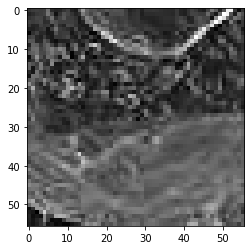

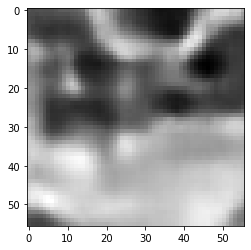

40.97624123096466

 next


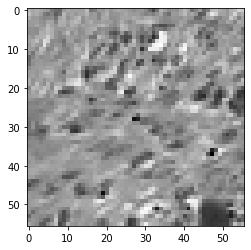

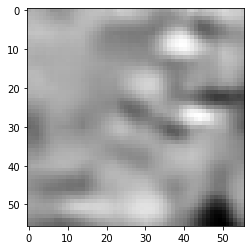

32.649128660559654

 next


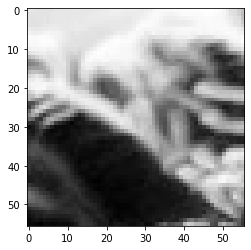

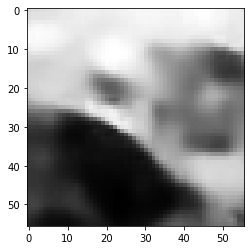

113.34544032812119

 next


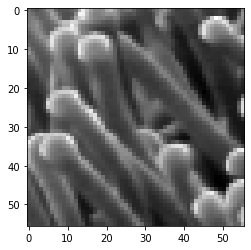

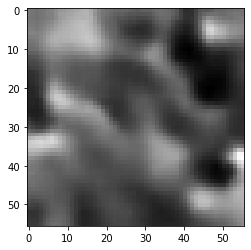

32.48085469007492

 next


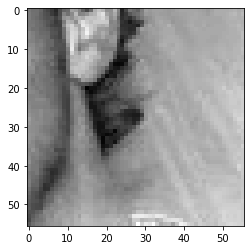

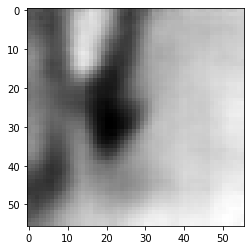

17.89441019296646

 next


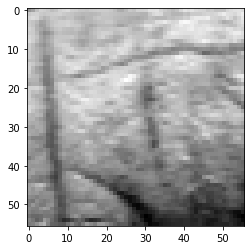

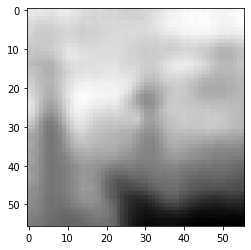

28.442887365818024

 next


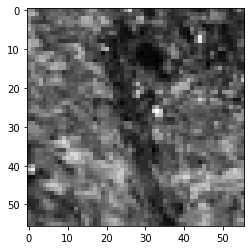

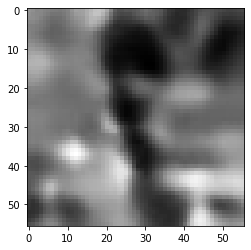

47.66221046447754

 next


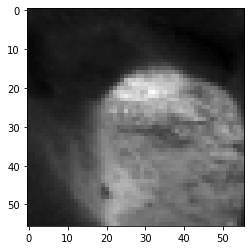

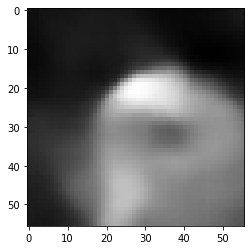

50.38577891886234

 next


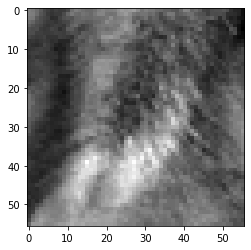

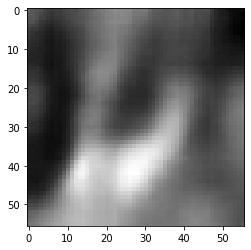

21.692853569984436

 next


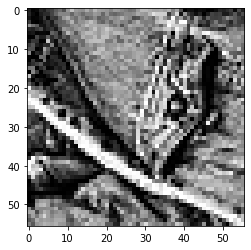

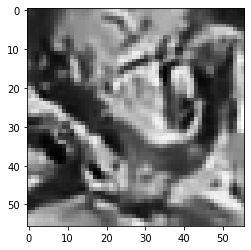

93.99054050445557

 next


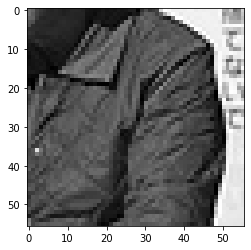

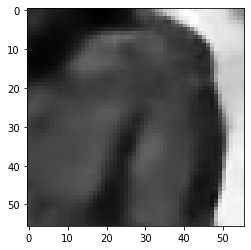

82.39744618535042

 next


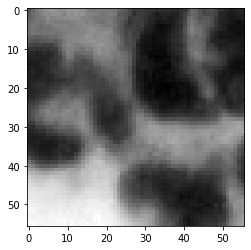

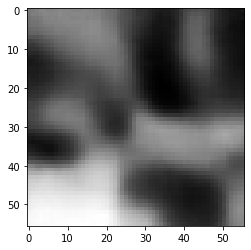

37.4282044172287

 next


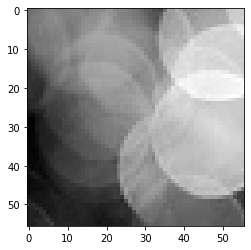

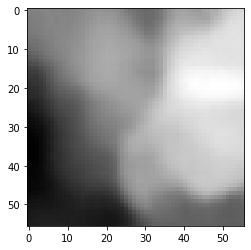

75.81513538956642

 next


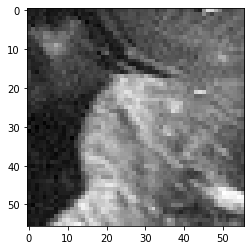

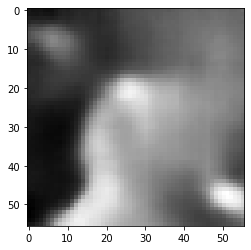

29.358947910368443

 next


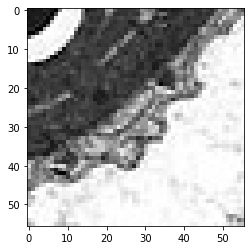

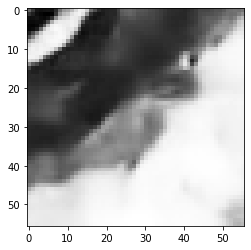

99.16400089859962

 next


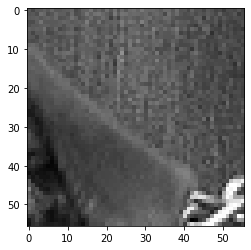

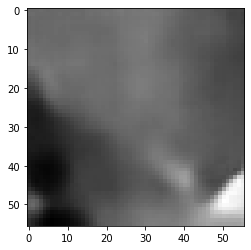

36.05444893240929

 next


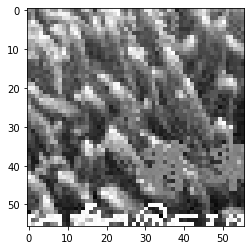

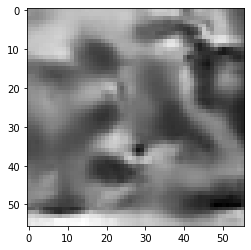

58.2563041895628

 next


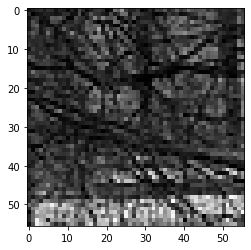

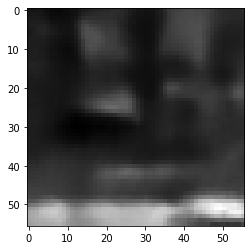

54.781018272042274

 next


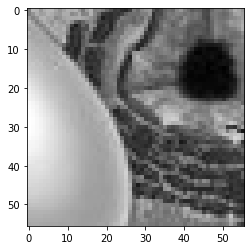

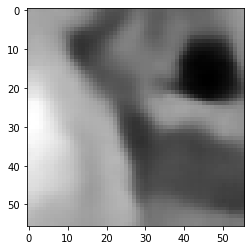

71.58374324440956

 next


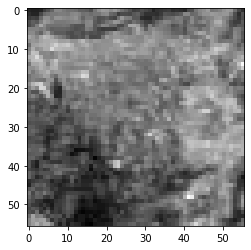

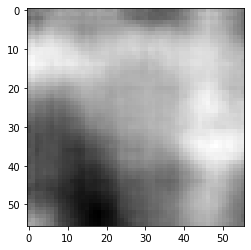

13.566260039806366

 next


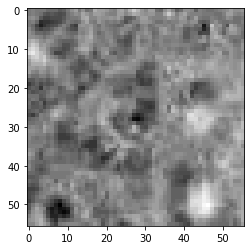

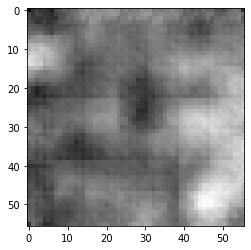

4.783984143286943

 next


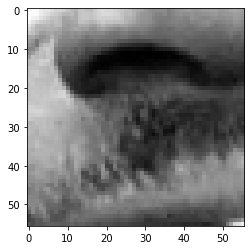

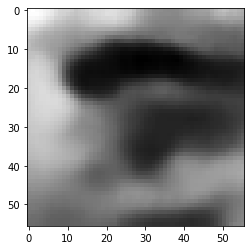

50.29463320970535

 next


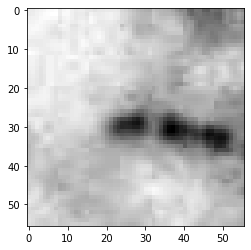

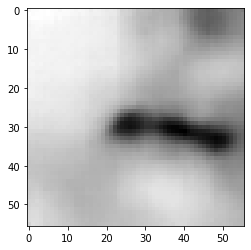

26.100685447454453

 next


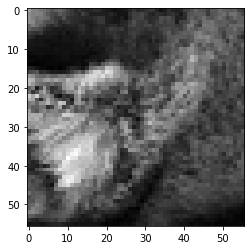

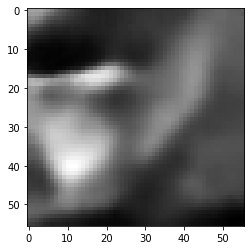

41.55917555093765

 next


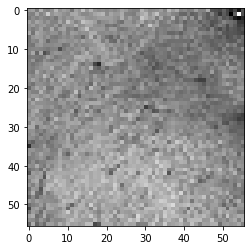

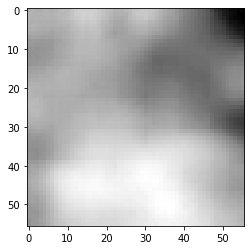

30.369277596473694

 next


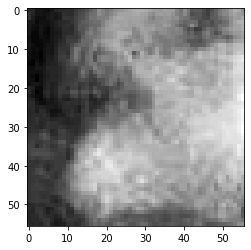

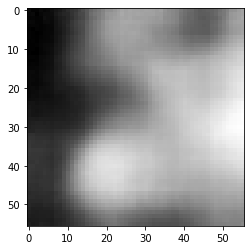

21.951499991118908

 next


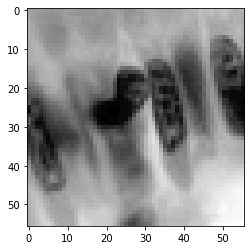

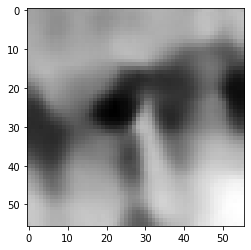

59.282906502485275

 next


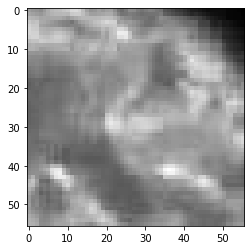

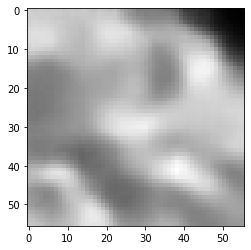

29.404269978404045

 next


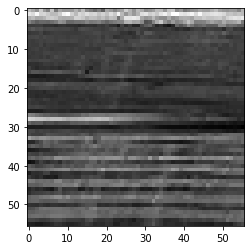

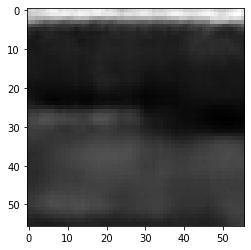

40.28113313019276

 next


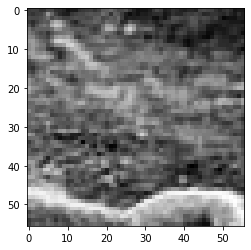

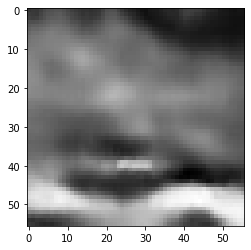

39.86741133034229

 next


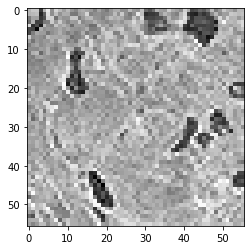

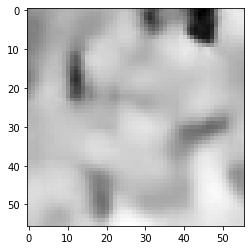

42.09186516702175

 next


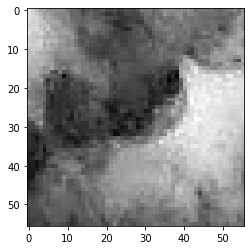

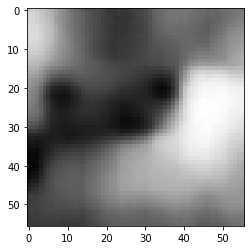

29.71391536295414

 next


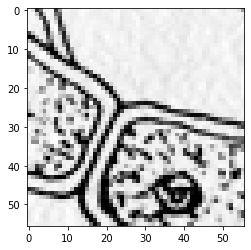

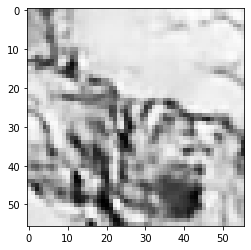

96.17794632911682

 next


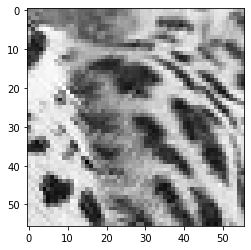

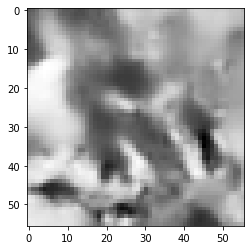

68.74986290931702

 next


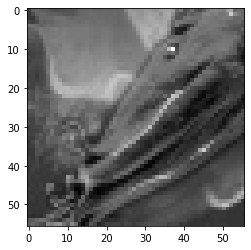

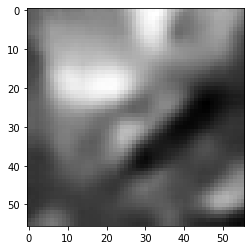

34.37542922794819

 next


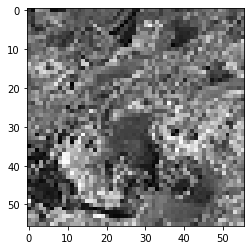

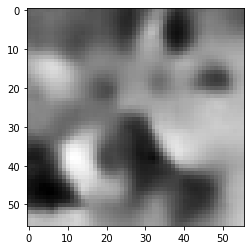

55.0263787060976

 next


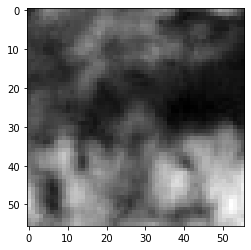

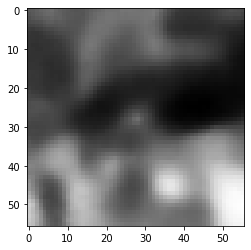

47.69782215356827

 next


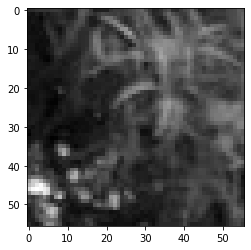

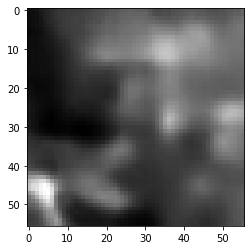

28.878406696021557

 next


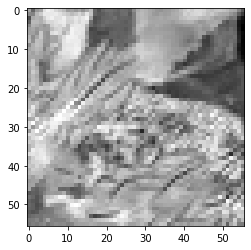

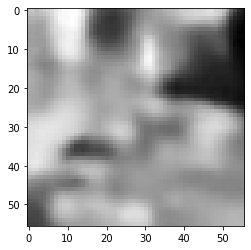

52.212097719311714

 next


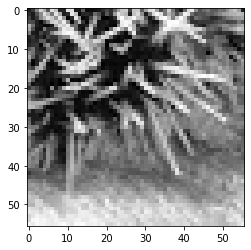

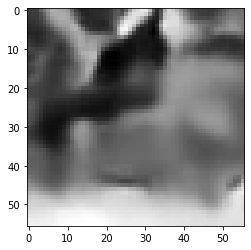

76.47383764386177

 next


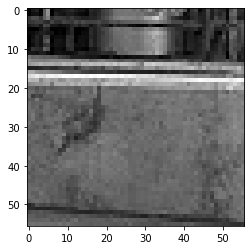

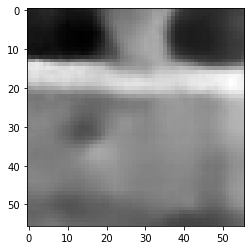

44.346679374575615

 next


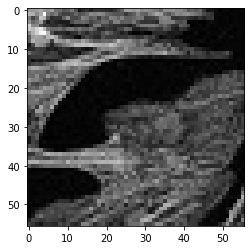

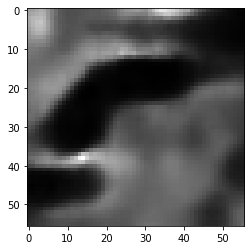

32.1976862847805

 next


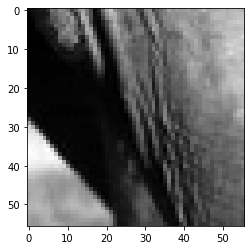

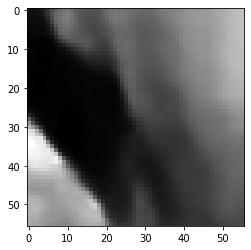

59.28640231490135

 next


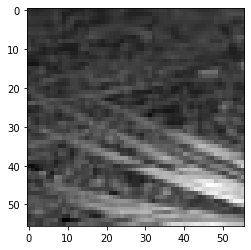

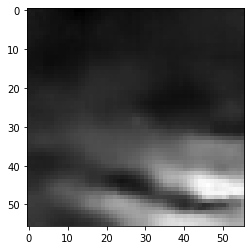

32.668036445975304

 next


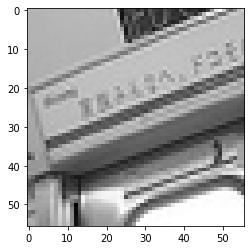

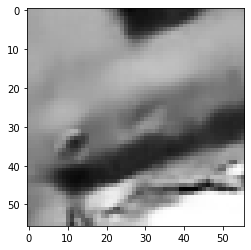

71.0493703186512

 next


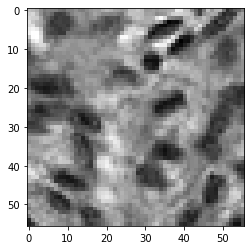

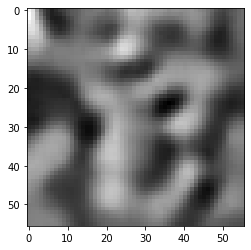

41.54034376144409

 next


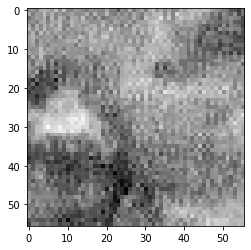

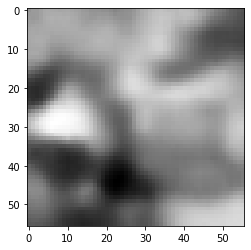

49.276846423745155

 next


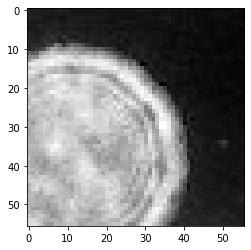

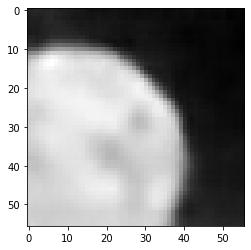

66.18939310312271

 next


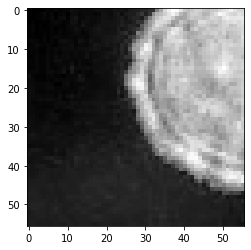

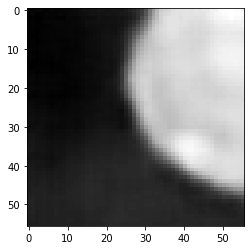

58.334834575653076

 next


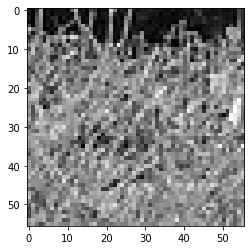

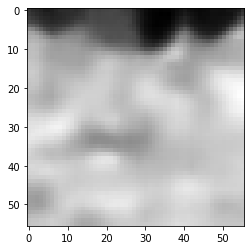

60.46564623713493

 next


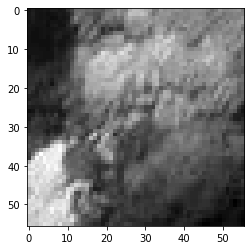

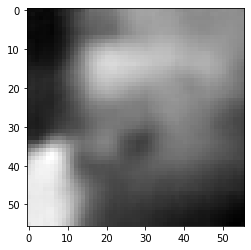

28.020370937883854

 next


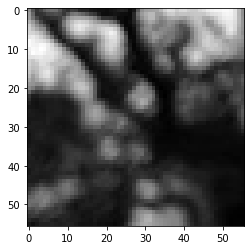

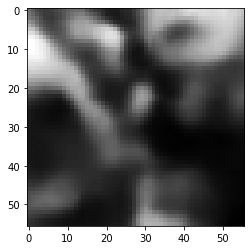

59.70281817018986

 next


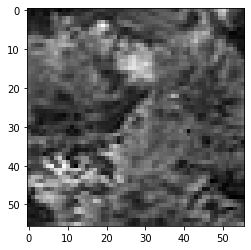

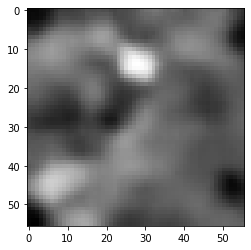

30.425624772906303

 next


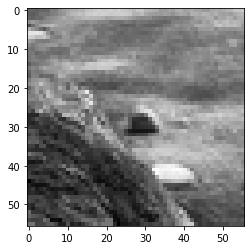

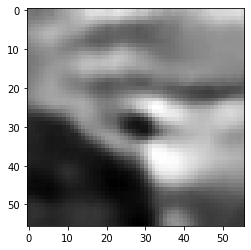

54.664045348763466

 next


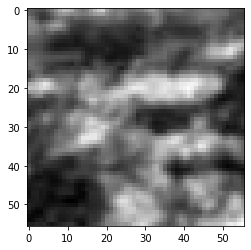

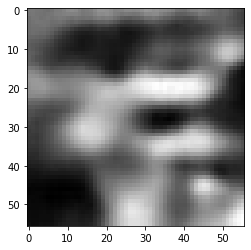

31.172096617519855

 next


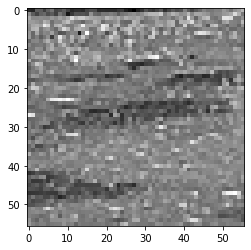

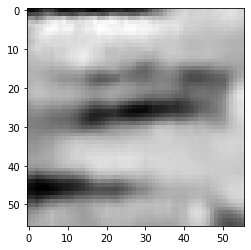

33.58928941190243

 next


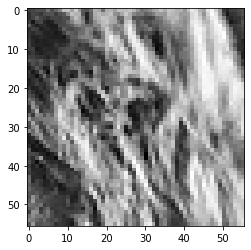

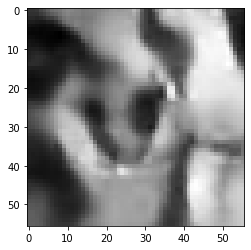

73.77409771084785

 next


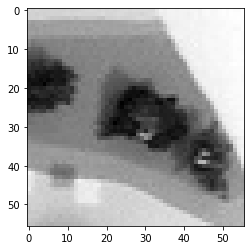

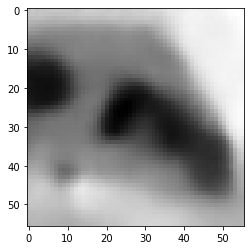

59.42449450492859

 next


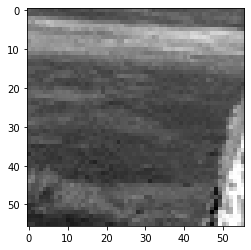

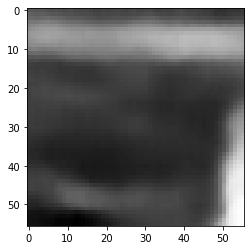

50.804721638560295

 next


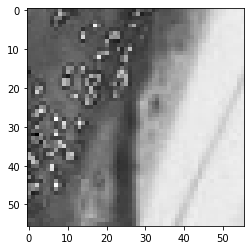

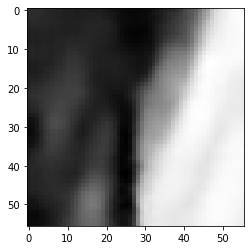

76.08636483550072

 next


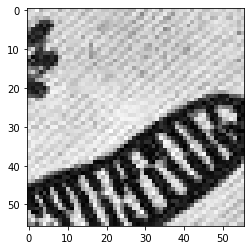

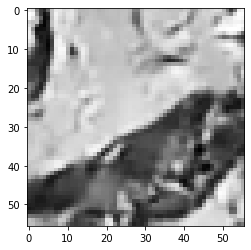

93.37347641587257

 next


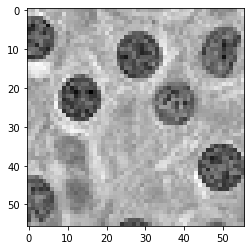

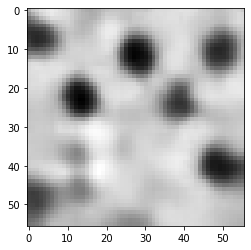

50.17679013311863

 next


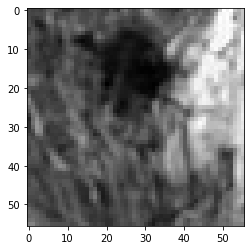

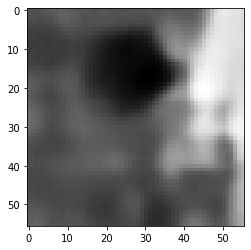

68.35889428853989

 next


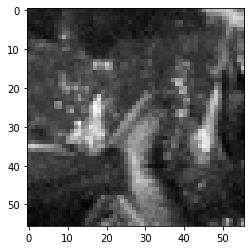

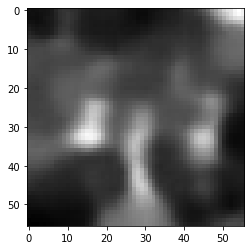

34.13425616919994

 next


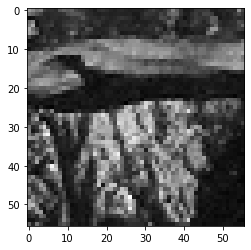

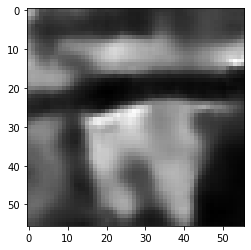

60.11707954108715

 next


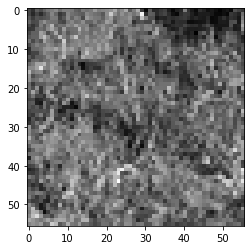

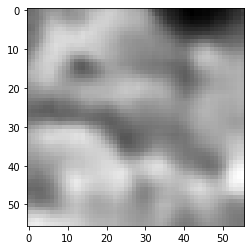

31.97640135884285

 next


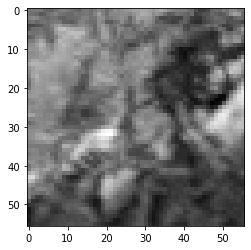

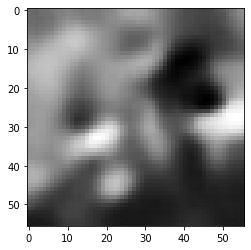

40.12028396129608

 next


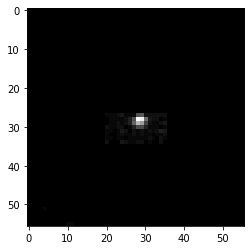

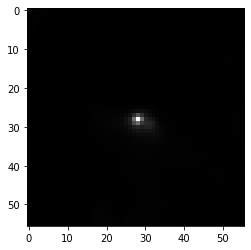

1.2215696135535836

 next


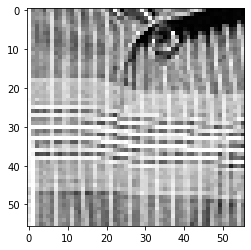

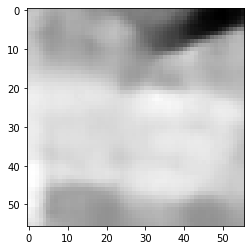

71.48834556341171

 next


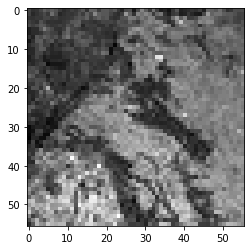

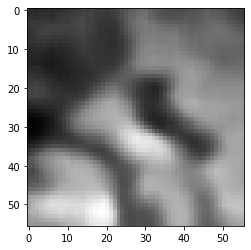

30.454685613512993

 next


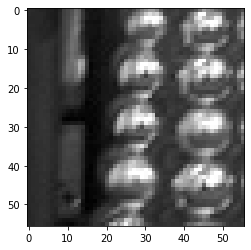

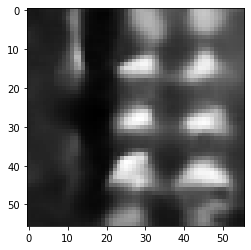

74.32048559188843

 next


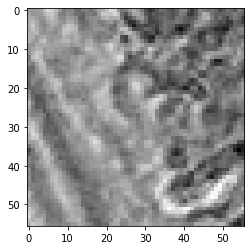

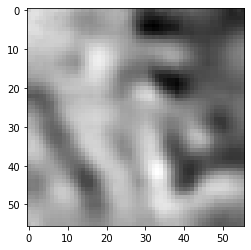

30.57730123400688

 next


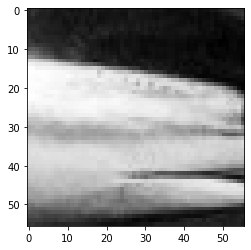

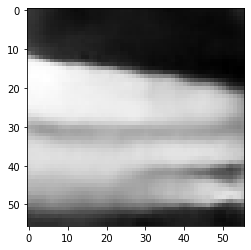

100.48358649015427

 next


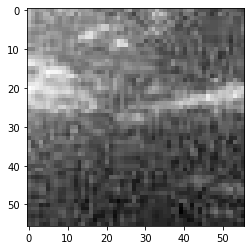

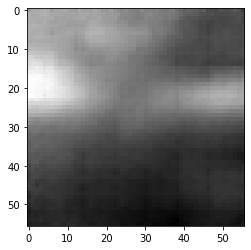

10.847254190593958

 next


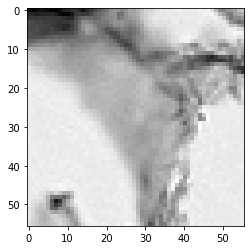

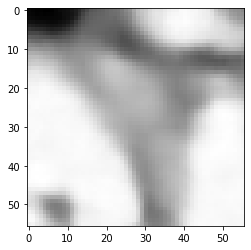

60.5627766251564

 next


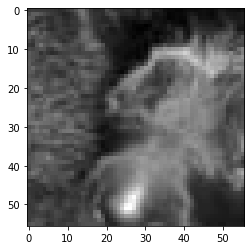

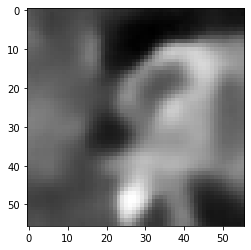

45.946868509054184

 next


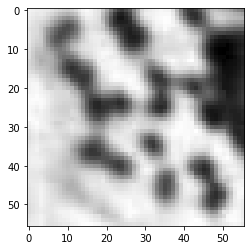

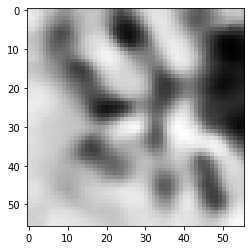

49.8147189617157

 next


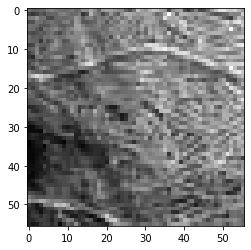

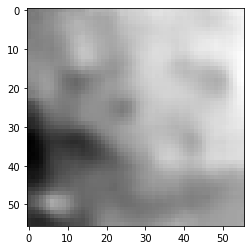

37.692909613251686

 next


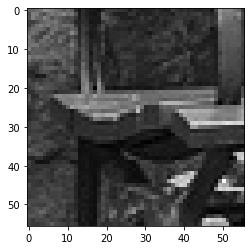

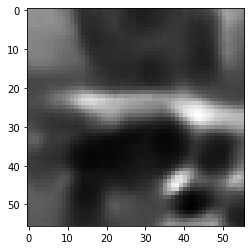

35.63070327043533

 next


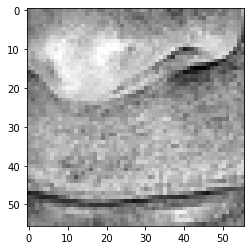

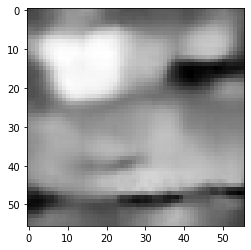

47.215225249528885

 next


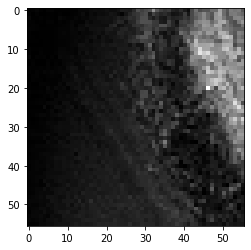

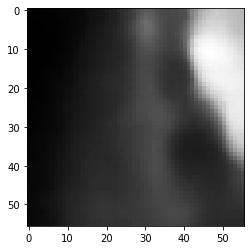

48.965703919529915

 next


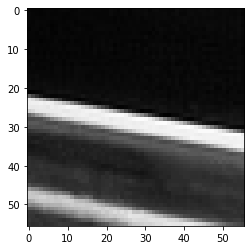

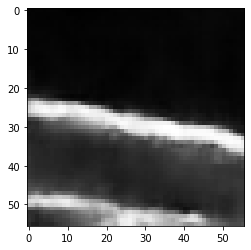

92.84388363361359

 next


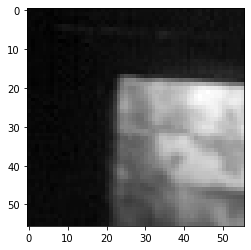

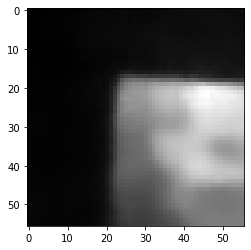

67.9040738940239

 next


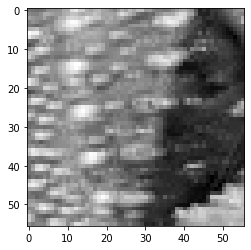

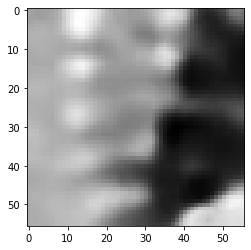

55.9667294472456

 next


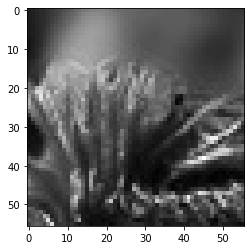

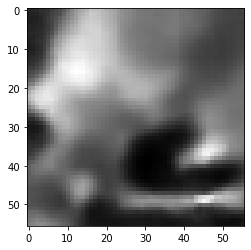

34.428497180342674

 next


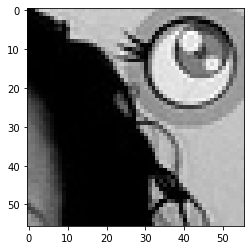

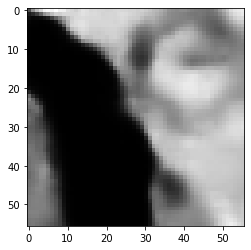

89.8616136610508

 next


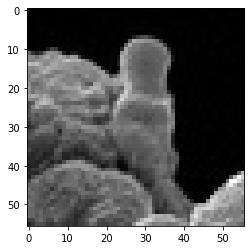

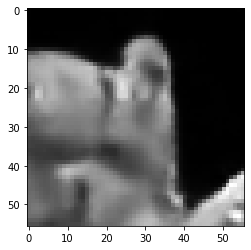

84.69345018267632

 next


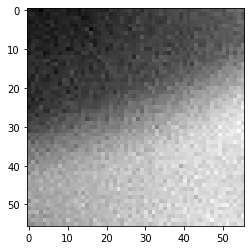

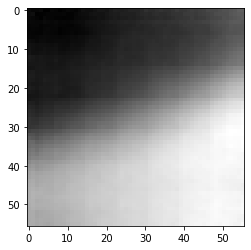

22.43402849882841

 next


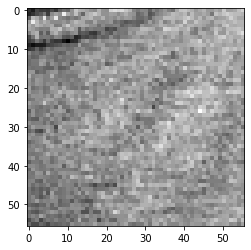

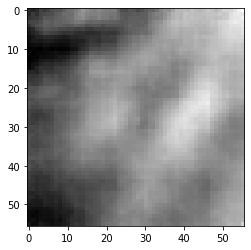

9.758178479969501

 next


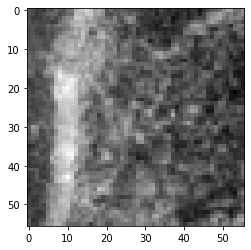

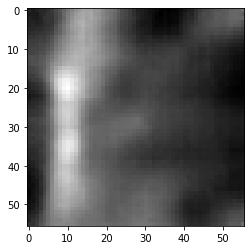

13.37619898840785

 next


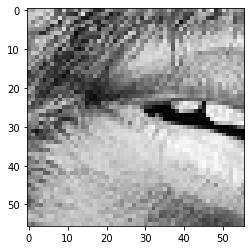

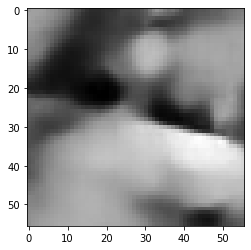

67.2166907787323

 next


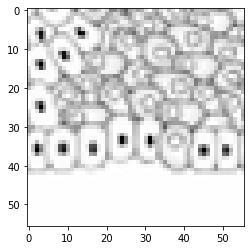

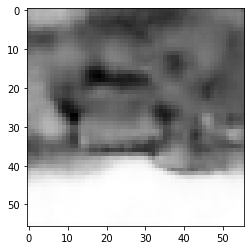

46.869181618094444

 next


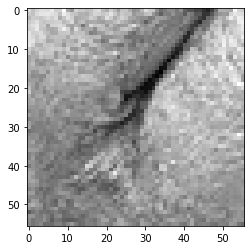

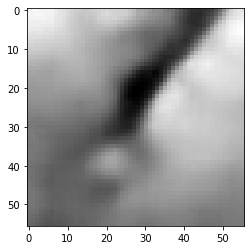

41.55396983027458

 next


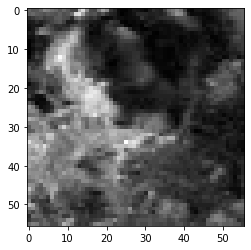

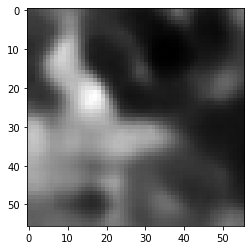

39.46124732494354

 next


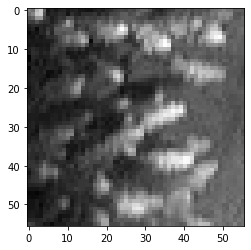

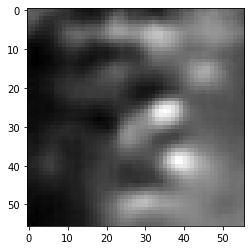

21.564112678170204

 next


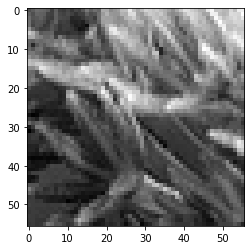

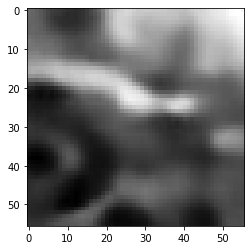

65.64932808279991

 next


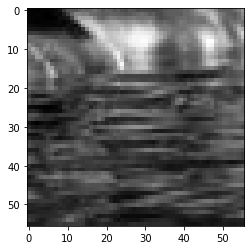

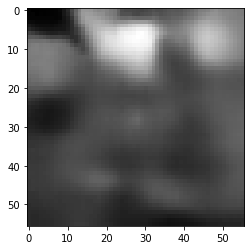

41.64955370128155

 next


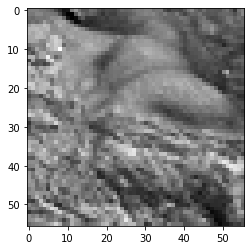

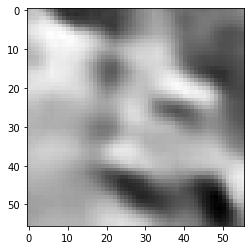

32.51682735979557

 next


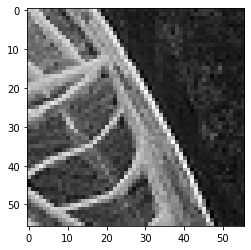

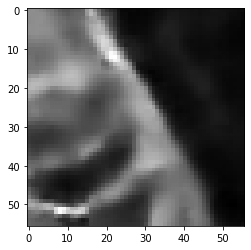

66.165971159935

 next


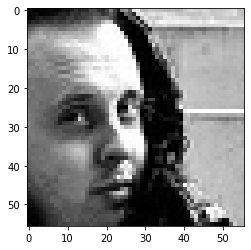

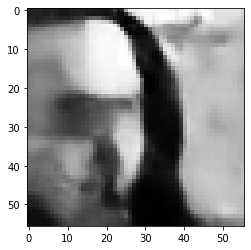

112.06544861197472

 next
0.1943410140555352


In [32]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')
